In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from collections import Counter
from typing import List, Any, Dict, Tuple
import io, zipfile, urllib.request
import time

from scipy.stats import chi2_contingency, ks_2samp
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from joblib import Parallel, delayed

In [ ]:
splits = {'train': 'train_data.csv', 'validation': 'validation_data.csv'}
df = pd.read_csv("hf://datasets/ETdanR/adult_income/" + splits["train"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
RNG = 0
np.random.seed(RNG)

In [ ]:
df.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,28,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Poland,>50K
1,53,Private,HS-grad,9,Divorced,Exec-managerial,Not-in-family,Black,Female,0,0,40,United-States,<=50K
2,32,Private,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,49,Private,Bachelors,13,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,1977,50,South,>50K
4,30,Private,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K


In [ ]:
print("Shape:", df.shape)

Shape: (11208, 14)


In [ ]:
print("Columns:", df.columns.tolist())

Columns: ['age', 'workclass', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


In [ ]:
print("\nTotal number of columns:", len(df.columns))


Total number of columns: 14


In [ ]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11208 entries, 0 to 11207
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              11208 non-null  int64 
 1   workclass        11208 non-null  object
 2   education        11208 non-null  object
 3   educational-num  11208 non-null  int64 
 4   marital-status   11208 non-null  object
 5   occupation       11208 non-null  object
 6   relationship     11208 non-null  object
 7   race             11208 non-null  object
 8   gender           11208 non-null  object
 9   capital-gain     11208 non-null  int64 
 10  capital-loss     11208 non-null  int64 
 11  hours-per-week   11208 non-null  int64 
 12  native-country   11208 non-null  object
 13  income           11208 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.2+ MB


In [ ]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
age                0
workclass          0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


In [ ]:
unique_counts = df.nunique().sort_values(ascending=False)
print("\nUnique counts per column:")
print(unique_counts)


Unique counts per column:
capital-gain       91
hours-per-week     87
age                71
capital-loss       71
native-country     39
education          16
educational-num    16
occupation         14
marital-status      7
workclass           7
relationship        6
race                5
gender              2
income              2
dtype: int64


In [ ]:
df.describe()

,age,educational-num,capital-gain,capital-loss,hours-per-week
count,11208.000000,11208.000000,11208.000000,11208.000000,11208.000000
mean,40.451374,10.633030,2139.106620,127.204854,42.507852
std,12.736954,2.591308,10774.752525,487.023664,11.744671
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,31.000000,9.000000,0.000000,0.000000,40.000000
50%,40.000000,10.000000,0.000000,0.000000,40.000000
75%,49.000000,13.000000,0.000000,0.000000,50.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


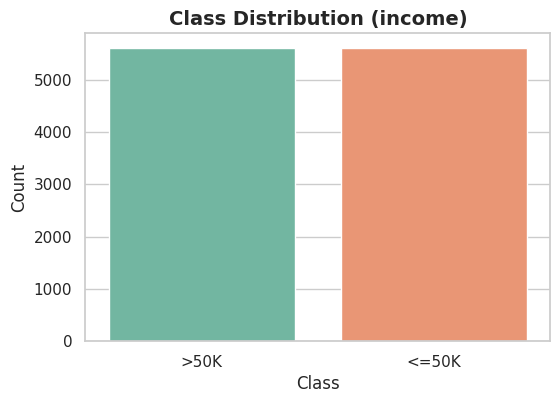

In [ ]:
target = 'income'
plt.figure(figsize=(6,4))
sns.countplot(data=df, x=target, palette='Set2')
plt.title(f"Class Distribution ({target})", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count")
plt.show()

In [ ]:
print("\nClass Value Counts:")
print(df[target].value_counts())
print("\nClass Proportions:")
print(df[target].value_counts() / len(df))


Class Value Counts:
income
>50K     5604
<=50K    5604
Name: count, dtype: int64

Class Proportions:
income
>50K     0.5
<=50K    0.5
Name: count, dtype: float64


In [ ]:
X = df.drop(target, axis=1)
y = df[target]

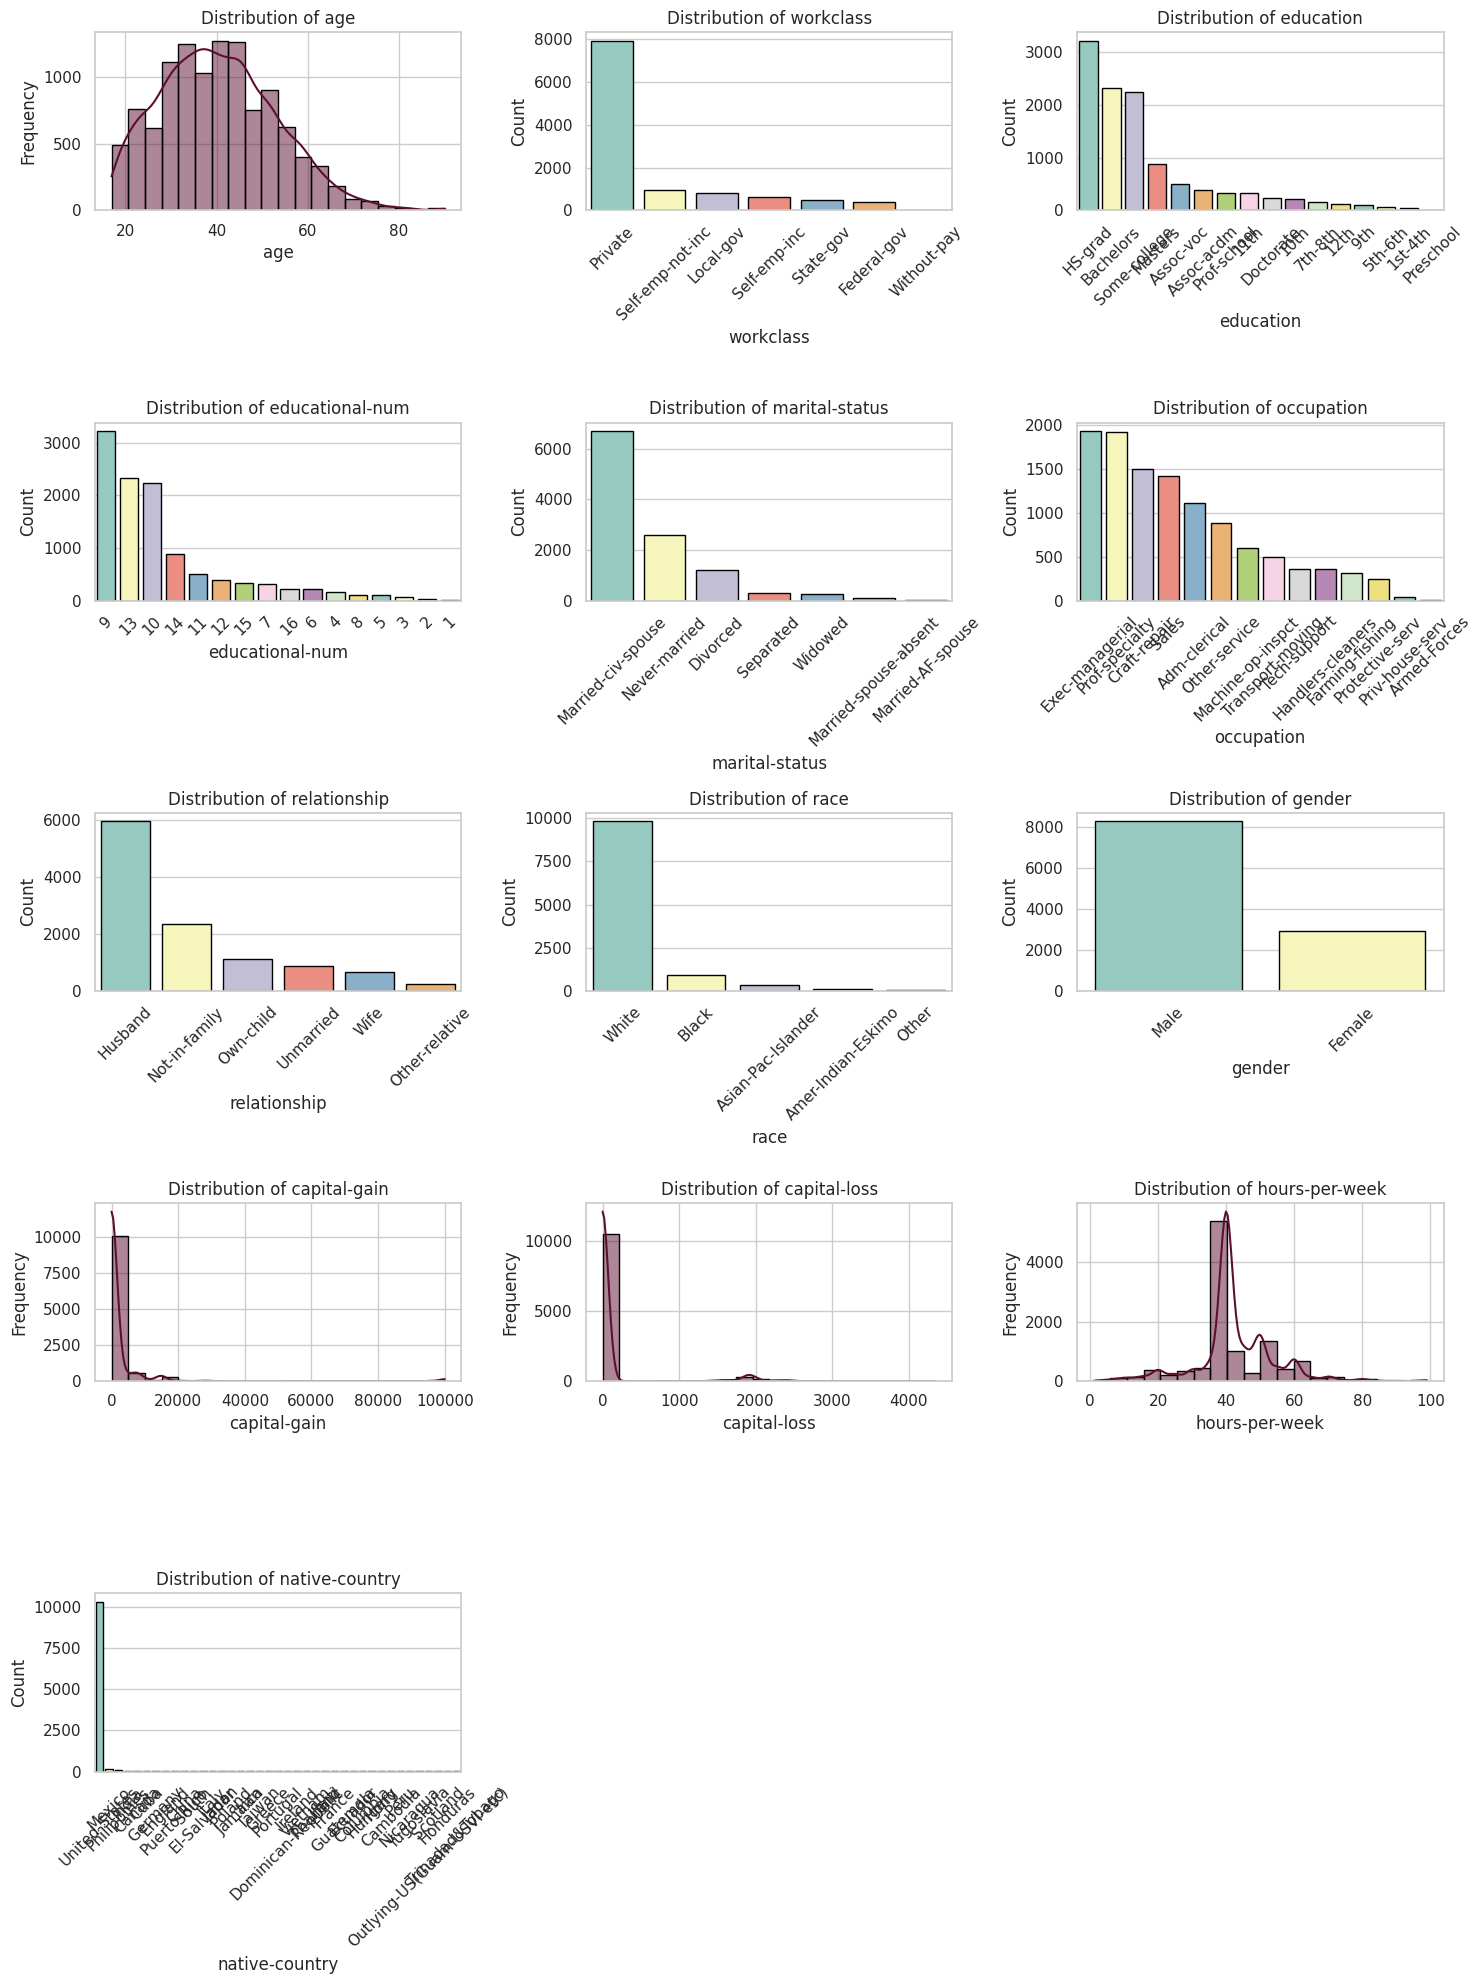

In [ ]:
num_columns = len(X.columns)
cols = 3
rows = math.ceil(num_columns / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

for i, column in enumerate(X.columns):

    ax = axes[i]

    is_categorical = (
        X[column].dtype == 'object'
        or X[column].dtype.name == 'category'
        or X[column].nunique() < 20
    )

    if is_categorical:
        vc = X[column].value_counts()
        sns.barplot(
            x=vc.index.astype(str),
            y=vc.values,
            ax=ax,
            palette="Set3",
            edgecolor="black"
        )
        ax.set_title(f'Distribution of {column}', fontsize=12)
        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', rotation=45)

    else:
        sns.histplot(
            X[column],
            kde=True,
            bins=20,
            ax=ax,
            edgecolor="black",
            color="#5c1031"
        )
        ax.set_title(f'Distribution of {column}', fontsize=12)
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
features = [c for c in df.columns if c != 'income']

In [ ]:
print("Top-5 categories per feature (count):")

for feat in features:
    vc = df[feat].value_counts().head(5)
    nunique = df[feat].nunique()

    print(f"\n{feat} (n_unique={nunique}):")
    print(vc.to_string())

Top-5 categories per feature (count):

age (n_unique=71):
age
38    349
37    343
36    338
45    337
34    333

workclass (n_unique=7):
workclass
Private             7924
Self-emp-not-inc     974
Local-gov            807
Self-emp-inc         608
State-gov            481

education (n_unique=16):
education
HS-grad         3220
Bachelors       2333
Some-college    2242
Masters          890
Assoc-voc        503

educational-num (n_unique=16):
educational-num
9     3220
13    2333
10    2242
14     890
11     503

marital-status (n_unique=7):
marital-status
Married-civ-spouse    6690
Never-married         2599
Divorced              1224
Separated              302
Widowed                260

occupation (n_unique=14):
occupation
Exec-managerial    1930
Prof-specialty     1921
Craft-repair       1495
Sales              1420
Adm-clerical       1117

relationship (n_unique=6):
relationship
Husband          5970
Not-in-family    2346
Own-child        1132
Unmarried         863
Wife             

In [ ]:
X_num = X.select_dtypes(include=['int64', 'float64'])

Numerical features: 5


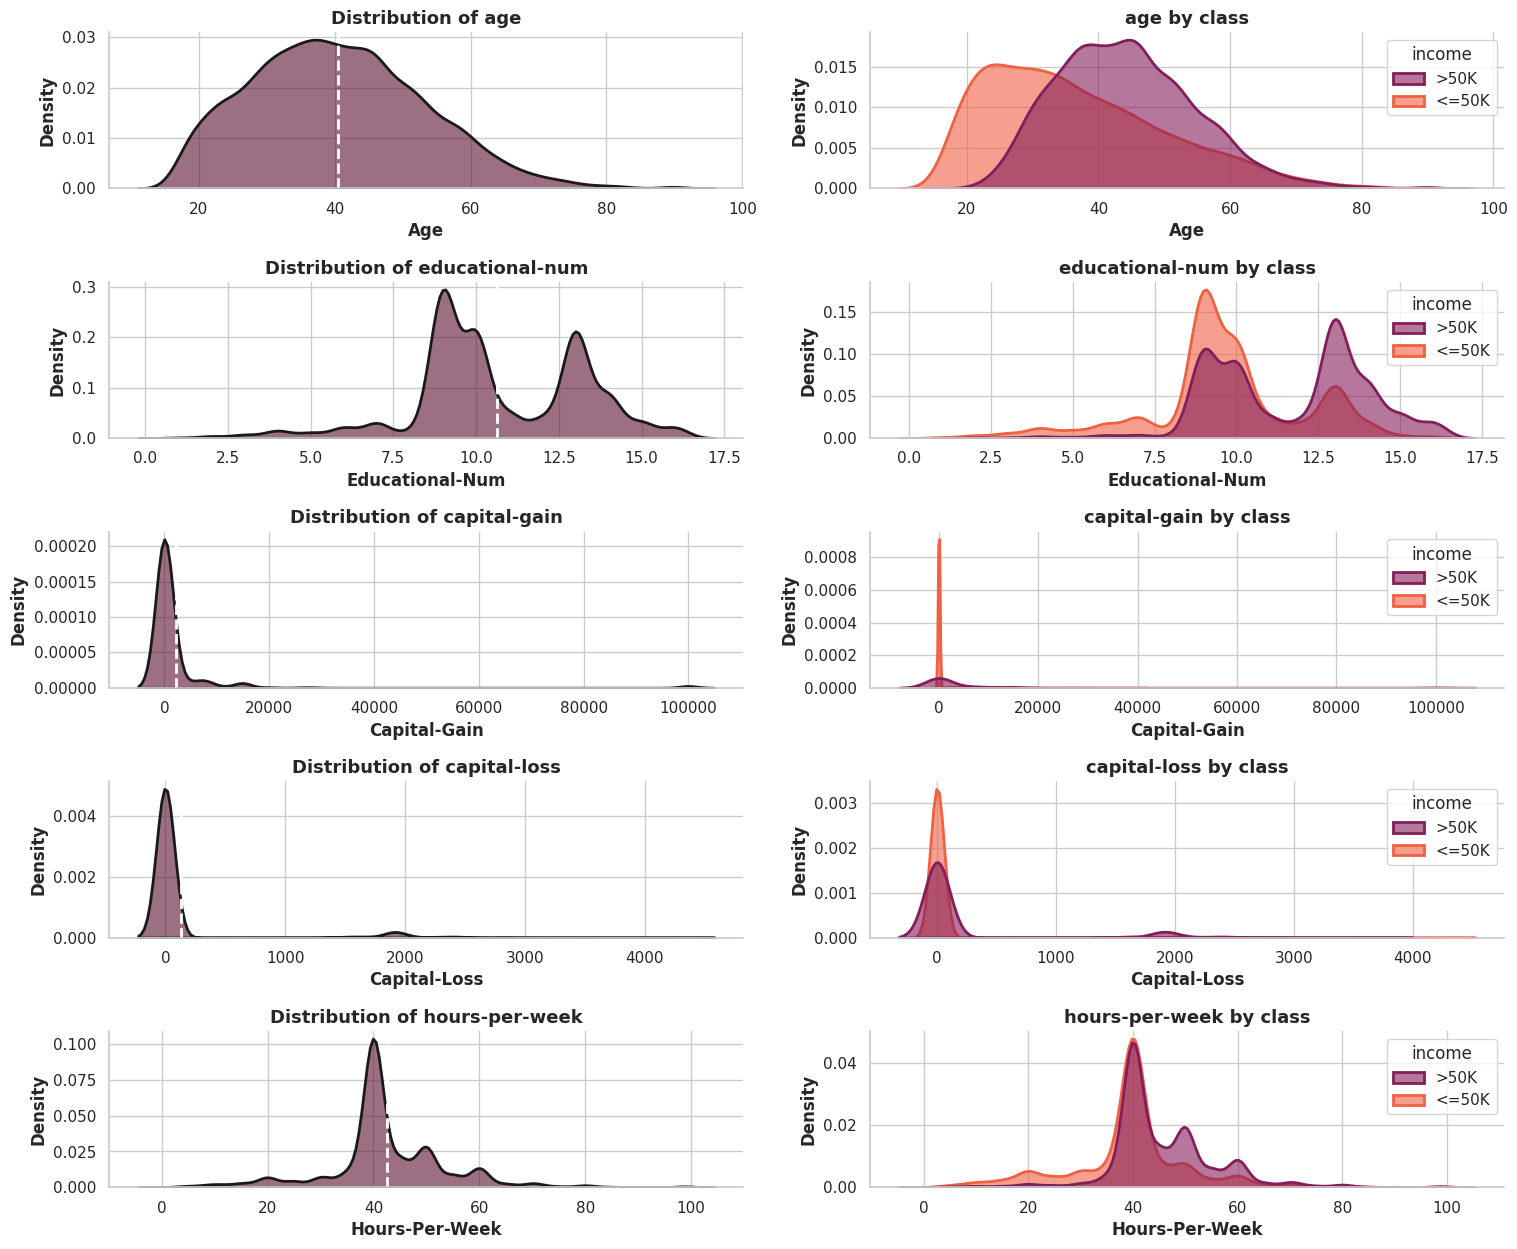

In [ ]:
print(f"Numerical features: {len(X_num.columns)}")
if len(X_num.columns) == 0:
    raise ValueError("No numerical features for KDE. Categorical ones should be encoded.")

plt.figure(figsize=(18, max(15, len(X_num.columns) * 3)))

plotIndex = 1

for i, col in enumerate(X_num.columns, start=1):

    plt.subplot(len(X_num.columns), 2, plotIndex)
    sns.kdeplot(
        data=X_num, x=col,
        fill=True, linewidth=2, color='#5c1031',
        alpha=0.6, edgecolor='k'
    )
    plt.axvline(X_num[col].mean(), color='white', linestyle='--', linewidth=2)
    plt.xlabel(col.title(), fontsize=12, weight='bold')
    plt.ylabel('Density', fontsize=12, weight='bold')
    plt.title(f'Distribution of {col}', fontsize=13, weight='bold')
    sns.despine()

    plt.subplot(len(X_num.columns), 2, plotIndex + 1)
    sns.kdeplot(
        data=X_num.join(y),
        x=col,
        hue=y.name,
        fill=True,
        linewidth=2,
        palette='rocket',
        alpha=0.6
    )
    plt.xlabel(col.title(), fontsize=12, weight='bold')
    plt.ylabel('Density', fontsize=12, weight='bold')
    plt.title(f'{col} by class', fontsize=13, weight='bold')
    sns.despine()

    plotIndex += 2

plt.subplots_adjust(hspace=0.6)
plt.show()

In [ ]:
if y.dtype == 'object' or str(y.dtype).startswith('category'):
    y_encoded = y.astype('category').cat.codes
else:
    y_encoded = y.copy()

In [ ]:
X_num = X.select_dtypes(include=['int64', 'float64'])

print(f"Numerical features for correlation: {len(X_num.columns)}")

Numerical features for correlation: 5


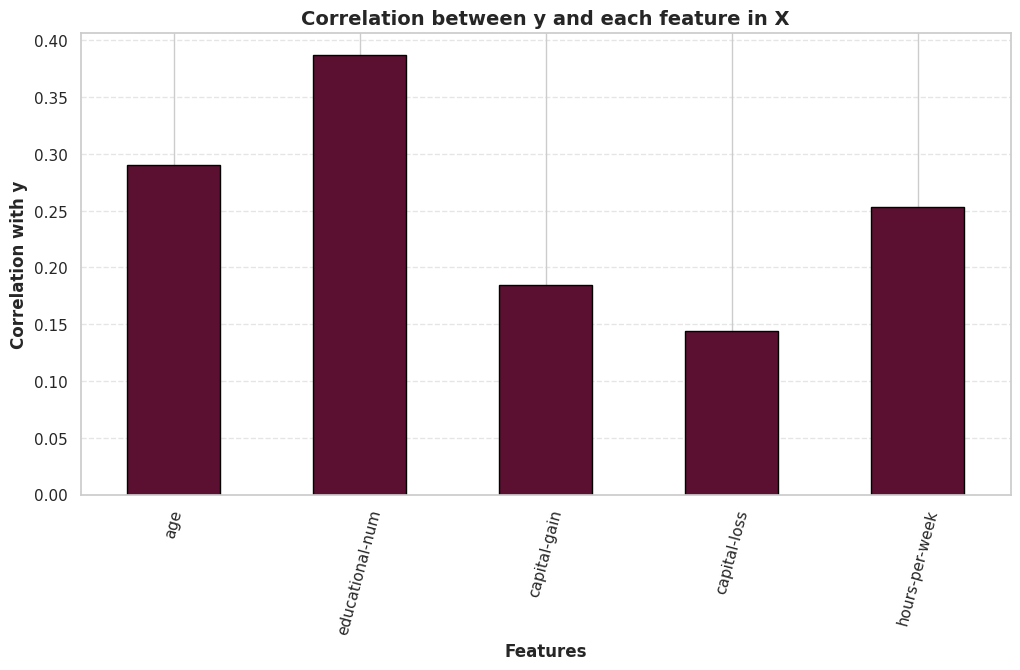

In [ ]:
correlations = X_num.corrwith(y_encoded)

plt.figure(figsize=(12, 6))
correlations.plot(kind='bar', color='#5c1031', edgecolor='black')

plt.title('Correlation between y and each feature in X', fontsize=14, weight='bold')
plt.xlabel('Features', fontsize=12, weight='bold')
plt.ylabel('Correlation with y', fontsize=12, weight='bold')

plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    phi2 = chi2 / n
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

In [ ]:
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical features: {len(cat_features)}")

Categorical features: 8


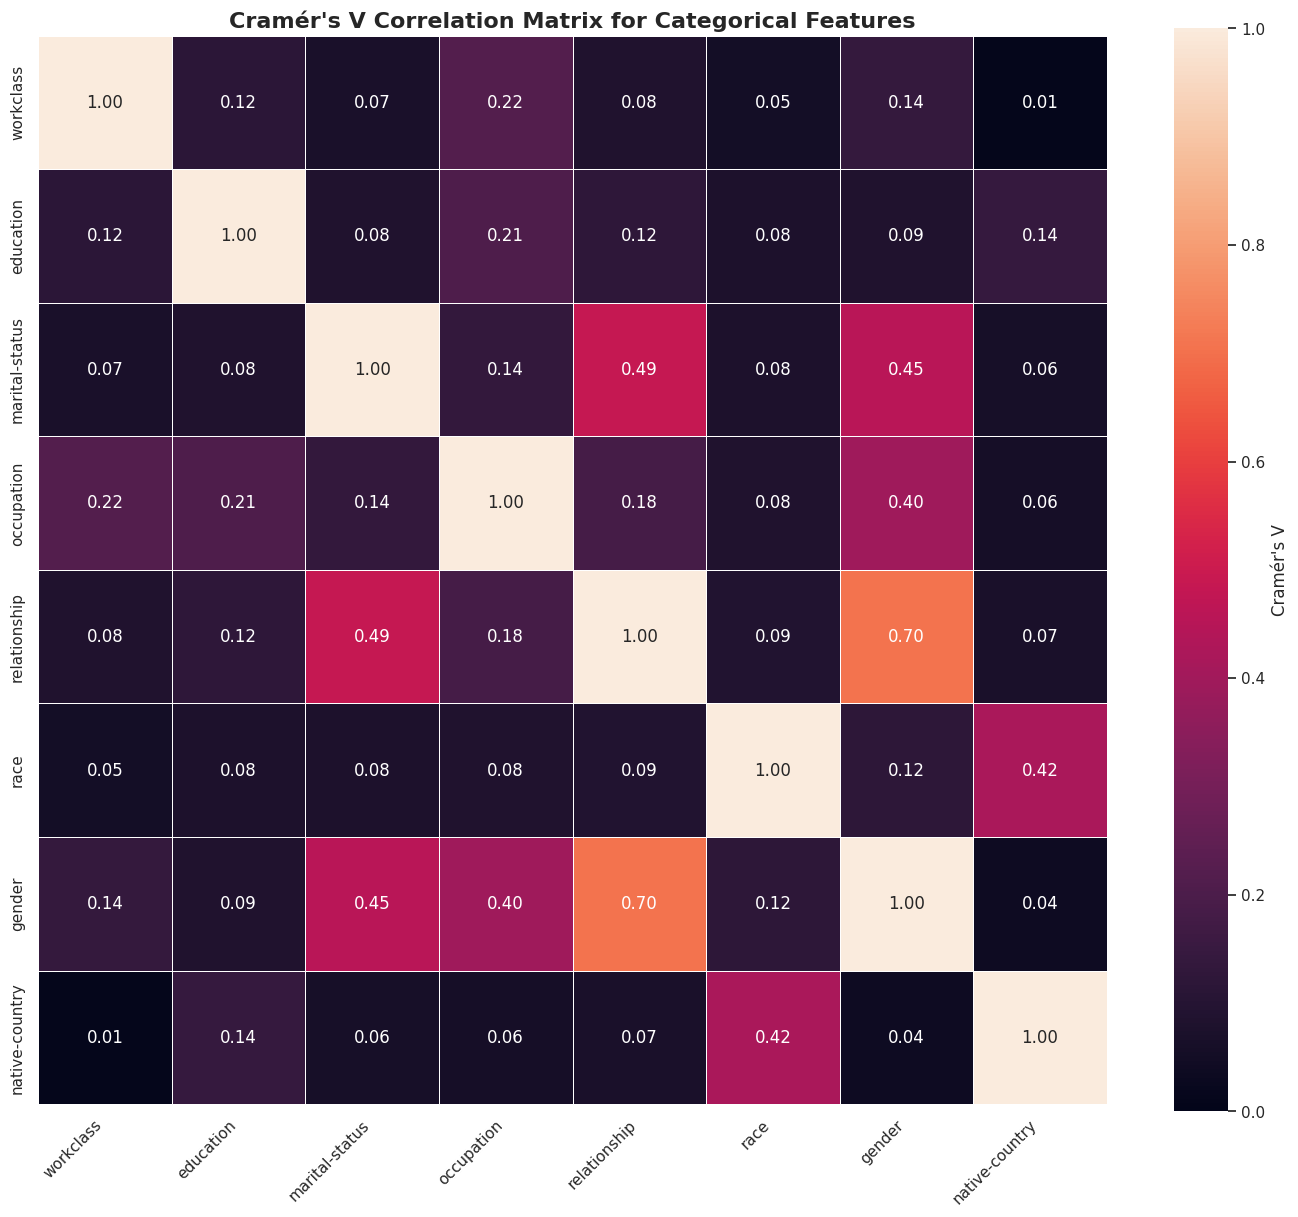

In [ ]:
cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_features), len(cat_features))),
    index=cat_features,
    columns=cat_features
)

for col1 in cat_features:
    for col2 in cat_features:
        cramer_matrix.loc[col1, col2] = cramers_v(X[col1], X[col2])

plt.figure(figsize=(14, 12))
sns.heatmap(
    cramer_matrix,
    annot=True,
    fmt=".2f",
    cmap="rocket",
    vmin=0, vmax=1,
    square=True,
    linewidths=.5,
    cbar_kws={'label': "Cramér's V"}
)

plt.title("Cramér's V Correlation Matrix for Categorical Features", fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Splitting the data

In [ ]:
X = df.drop(columns='income')
y = (df['income'] == '>50K').astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (8966, 13) Test shape: (2242, 13)


In [ ]:
RNG = 42

N_TRAIN_FCA = 800

sss_train_fca = StratifiedShuffleSplit(
    n_splits=1,
    train_size=N_TRAIN_FCA,
    random_state=RNG
)

for train_idx_fca, _ in sss_train_fca.split(X_train, y_train):
    X_train_ = X_train.iloc[train_idx_fca]
    y_train_ = y_train.iloc[train_idx_fca]

print("FCA train shape:", X_train_.shape, y_train_.shape)

FCA train shape: (800, 13) (800,)


In [ ]:
N_TEST_FCA = 200

sss_test_fca = StratifiedShuffleSplit(
    n_splits=1,
    test_size=N_TEST_FCA,
    random_state=RNG
)

for _, test_idx_fca in sss_test_fca.split(X_test, y_test):
    X_test_ = X_test.iloc[test_idx_fca]
    y_test_ = y_test.iloc[test_idx_fca]

print("FCA test shape:", X_test_.shape, y_test_.shape)

FCA test shape: (200, 13) (200,)


### Data Preprocessing for LazyFCA Classifier

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if target in numeric_cols:
	numeric_cols.remove(target)

categorical_cols = [c for c in df.columns if c not in numeric_cols + [target, 'income']]
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

Numeric cols: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical cols: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


In [ ]:
X_train_fca_preprocessed = pd.DataFrame(index=X_train_.index)

#binarization with One-Hot Encoding
for col in categorical_cols:
    for val in X[col].unique():
        X_train_fca_preprocessed[f"{col}_{val}"] = X[col] == val

#numerical features unchanged
X_train_fca_preprocessed[numeric_cols] = X[numeric_cols]

X_train_fca_preprocessed.head()

,workclass_Private,workclass_Local-gov,workclass_State-gov,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_Federal-gov,workclass_Without-pay,education_HS-grad,education_Bachelors,education_Prof-school,education_Assoc-voc,education_Doctorate,education_Masters,education_11th,education_Some-college,education_Assoc-acdm,education_10th,education_5th-6th,education_9th,education_12th,education_7th-8th,education_1st-4th,education_Preschool,marital-status_Married-civ-spouse,marital-status_Divorced,marital-status_Never-married,marital-status_Widowed,marital-status_Separated,marital-status_Married-spouse-absent,marital-status_Married-AF-spouse,occupation_Craft-repair,occupation_Exec-managerial,occupation_Sales,occupation_Prof-specialty,occupation_Transport-moving,occupation_Protective-serv,occupation_Adm-clerical,occupation_Machine-op-inspct,occupation_Other-service,occupation_Handlers-cleaners,occupation_Tech-support,occupation_Priv-house-serv,occupation_Farming-fishing,occupation_Armed-Forces,relationship_Husband,relationship_Not-in-family,relationship_Unmarried,relationship_Own-child,relationship_Wife,relationship_Other-relative,race_White,race_Black,race_Asian-Pac-Islander,race_Other,race_Amer-Indian-Eskimo,gender_Male,gender_Female,native-country_Poland,native-country_United-States,native-country_South,native-country_France,native-country_Japan,native-country_Philippines,native-country_Jamaica,native-country_Cuba,native-country_India,native-country_Taiwan,native-country_Mexico,native-country_England,native-country_Vietnam,native-country_Puerto-Rico,native-country_Greece,native-country_Hong,native-country_Guatemala,native-country_Canada,native-country_El-Salvador,native-country_China,native-country_Dominican-Republic,native-country_Scotland,native-country_Outlying-US(Guam-USVI-etc),native-country_Italy,native-country_Nicaragua,native-country_Columbia,native-country_Haiti,native-country_Germany,native-country_Portugal,native-country_Honduras,native-country_Ireland,native-country_Cambodia,native-country_Peru,native-country_Yugoslavia,native-country_Thailand,native-country_Ecuador,native-country_Iran,native-country_Hungary,native-country_Trinadad&Tobago,age,educational-num,capital-gain,capital-loss,hours-per-week
1349,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,52,13,15024,0,50
6607,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,40,10,7298,0,40
114,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [ ]:
X_train_fca_preprocessed.shape

(800, 101)

In [ ]:
y_train_.shape

(800,)

In [ ]:
X_test_fca_preprocessed = pd.DataFrame(index=X_test_.index)

# same - binarization with One-Hot Encoding
for col in categorical_cols:
    for val in X[col].unique():
        X_test_fca_preprocessed[f"{col}_{val}"] = X[col] == val

# numerical features unchanged
X_test_fca_preprocessed[numeric_cols] = X[numeric_cols]

X_test_fca_preprocessed.head()

,workclass_Private,workclass_Local-gov,workclass_State-gov,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_Federal-gov,workclass_Without-pay,education_HS-grad,education_Bachelors,education_Prof-school,education_Assoc-voc,education_Doctorate,education_Masters,education_11th,education_Some-college,education_Assoc-acdm,education_10th,education_5th-6th,education_9th,education_12th,education_7th-8th,education_1st-4th,education_Preschool,marital-status_Married-civ-spouse,marital-status_Divorced,marital-status_Never-married,marital-status_Widowed,marital-status_Separated,marital-status_Married-spouse-absent,marital-status_Married-AF-spouse,occupation_Craft-repair,occupation_Exec-managerial,occupation_Sales,occupation_Prof-specialty,occupation_Transport-moving,occupation_Protective-serv,occupation_Adm-clerical,occupation_Machine-op-inspct,occupation_Other-service,occupation_Handlers-cleaners,occupation_Tech-support,occupation_Priv-house-serv,occupation_Farming-fishing,occupation_Armed-Forces,relationship_Husband,relationship_Not-in-family,relationship_Unmarried,relationship_Own-child,relationship_Wife,relationship_Other-relative,race_White,race_Black,race_Asian-Pac-Islander,race_Other,race_Amer-Indian-Eskimo,gender_Male,gender_Female,native-country_Poland,native-country_United-States,native-country_South,native-country_France,native-country_Japan,native-country_Philippines,native-country_Jamaica,native-country_Cuba,native-country_India,native-country_Taiwan,native-country_Mexico,native-country_England,native-country_Vietnam,native-country_Puerto-Rico,native-country_Greece,native-country_Hong,native-country_Guatemala,native-country_Canada,native-country_El-Salvador,native-country_China,native-country_Dominican-Republic,native-country_Scotland,native-country_Outlying-US(Guam-USVI-etc),native-country_Italy,native-country_Nicaragua,native-country_Columbia,native-country_Haiti,native-country_Germany,native-country_Portugal,native-country_Honduras,native-country_Ireland,native-country_Cambodia,native-country_Peru,native-country_Yugoslavia,native-country_Thailand,native-country_Ecuador,native-country_Iran,native-country_Hungary,native-country_Trinadad&Tobago,age,educational-num,capital-gain,capital-loss,hours-per-week
763,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,24,10,0,0,40
7256,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,42,9,0,0,50
9488,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,28

In [ ]:
X_test_fca_preprocessed.shape

(200, 101)

### Lazy FCA Vanilla Run

In [ ]:
class LazyClassifierFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train

    def classify_sample(self, sample: pd.Series) -> Any:
        X_train_positive = self.X_train[y_train == 1]
        X_train_negative = self.X_train[y_train == 0]

        positive_classifiers = 0
        negative_classifiers = 0

        binary_X_train_positive = X_train_positive.select_dtypes(include='bool')
        numerical_X_train_positive = X_train_positive.select_dtypes(exclude='bool')
        binary_X_train_negative = X_train_negative.select_dtypes(include='bool')
        numerical_X_train_negative = X_train_negative.select_dtypes(exclude='bool')


        def find_number_of_positive_and_negative_matches(binary_intersection, numerical_intervals):
            binary_positive_match = (binary_X_train_positive | ~binary_intersection).all(axis=1)
            binary_negative_match = (binary_X_train_negative | ~binary_intersection).all(axis=1)

            numerical_array_pos = numerical_X_train_positive.values
            numerical_array_neg = numerical_X_train_negative.sort_values

            intervals_array = np.array(numerical_intersection)

            numerical_positive_match = ((numerical_array_pos >= intervals_array[:,0]) &
                            (numerical_array_pos <= intervals_array[:,1])).all(axis=1)

            numerical_negative_match = ((numerical_array_neg >= intervals_array[:,0]) &
                            (numerical_array_neg <= intervals_array[:,1])).all(axis=1)


            num_positive = (binary_positive_match & numerical_positive_match).sum()
            num_negative = (binary_negative_match & numerical_negative_match).sum()
            return num_positive, num_negative

        def is_positive_classifier(binary_intersection, numerical_intervals):
            num_positive, num_negative = find_number_of_positive_and_negative_matches(binary_intersection, numerical_intervals)
            return num_negative == 0 and num_positive > 1

        def is_negative_classifier(binary_intersection, numerical_intervals):
            num_positive, num_negative = find_number_of_positive_and_negative_matches(binary_intersection, numerical_intervals)
            return num_positive == 0 and num_negative > 1

        for _, pos_sample in X_train_positive.iterrows():
            binary_intersection = sample[binary_X_train_positive.columns] & pos_sample[binary_X_train_positive.columns]

            numerical_intersection = [
                (min(sample[col], pos_sample[col]), max(sample[col], pos_sample[col]))
                for col in numerical_X_train_positive.columns
            ]

            if is_positive_classifier(binary_intersection, numerical_intersection):
                positive_classifiers += 1

        for _, neg_sample in X_train_negative.iterrows():
            binary_intersection = sample[binary_X_train_negative.columns] & neg_sample[binary_X_train_negative.columns]

            numerical_intersection = [
                (min(sample[col], neg_sample[col]), max(sample[col], neg_sample[col]))
                for col in numerical_X_train_negative.columns
            ]

            if is_negative_classifier(binary_intersection, numerical_intersection):
                negative_classifiers += 1

        if positive_classifiers > negative_classifiers:
            print(f"sample {sample.name} is classified as 1, {positive_classifiers=}, {negative_classifiers=}")
            return 1

        elif negative_classifiers > positive_classifiers:
            print(f"sample {sample.name} is classified as 0, {positive_classifiers=}, {negative_classifiers=}")
            return 0

        else:
            print(f"sample {sample.name} is classified as 1, default, {positive_classifiers=}, {negative_classifiers=}")

            return 1


    def predict(self, X_test: pd.DataFrame) -> List[Any]:
        predictions = []
        for _, sample in X_test.iterrows():
            prediction = self.classify_sample(sample)
            predictions.append(prediction)

        return predictions

In [ ]:
sample = X_test_fca_preprocessed.iloc[1]
y_test_.iloc[1]

np.int64(0)

In [ ]:
len(X_train_fca_preprocessed[y_train_ == 1]), len(X_train_fca_preprocessed[y_train_ == 0])

(400, 400)

In [ ]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_fca_preprocessed, y_train_)

In [ ]:
classifier.classify_sample(sample)

sample 7256 is classified as 0, positive_classifiers=0, negative_classifiers=48


0

Predicting using batches:

In [ ]:
BATCH = 50

In [ ]:
def predict_batch(X_batch):
    return [classifier.classify_sample(x) for _, x in X_batch.iterrows()]

In [ ]:
y_pred_fca = []
total_fca_time = []

for start in range(0, len(X_test_), BATCH):
    end = start + BATCH
    X_batch = X_test_fca_preprocessed.iloc[start:end]

    t0 = time.time()

    preds = Parallel(n_jobs=12)(
        delayed(classifier.classify_sample)(x)
        for _, x in X_batch.iterrows()
    )
    y_pred_fca.extend(preds)

    total_fca_time.append(time.time() - t0)
    print(f"Done batch {start}:{end} in {total_fca_time[-1]:.3f} seconds")

Done batch 0:50 in 115.171 seconds
Done batch 50:100 in 110.939 seconds
Done batch 100:150 in 113.487 seconds
Done batch 150:200 in 109.274 seconds


In [ ]:
print(y_pred_fca)

[0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]


In [ ]:
print("Classification report:")
print(classification_report(y_test_, y_pred_fca))

print("F1 score (macro):", f1_score(y_test_, y_pred_fca, average='macro'))
print("F1 score (weighted):", f1_score(y_test_, y_pred_fca, average='weighted'))

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       100
           1       0.79      0.91      0.85       100

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200

F1 score (macro): 0.8340666247642992
F1 score (weighted): 0.8340666247642992


### 1) Improving Lazy FCA Classifier:

Lazy FCA with parameters
- `min_support` (minimal number of class objects)  
- `top_k` (leaving only k strongest classifiers before voting)

In [ ]:
class LazyClassifierFCAImproved:
    def __init__(self, min_support=1, top_k=400):
        self.min_support = int(min_support)
        self.top_k = int(top_k)

        self.bin_cols = None
        self.num_cols = None
        self.n_bin = 0
        self.n_blocks = 0
        self.n_num = 0

        self.bin_pos = None
        self.bin_neg = None
        self.num_pos = None
        self.num_neg = None

    #packing helpers
    @staticmethod
    def _compute_nblocks(n_features: int) -> int:
        return (n_features + 63) // 64

    def _pack_bits_array(self, arr_uint8: np.ndarray, n_blocks: int) -> np.ndarray:
        n_samples, n_features = arr_uint8.shape
        packed = np.zeros((n_samples, n_blocks), dtype=np.uint64)
        for j in range(n_features):
            block = j // 64
            offset = j % 64

            packed[:, block] |= (arr_uint8[:, j].astype(np.uint64) << np.uint64(offset))
        return packed

    def _pack_bits_df(self, df_bool: pd.DataFrame, n_blocks: int) -> np.ndarray:
        if df_bool.shape[1] == 0:
            # no binary columns -> empty array with shape (n_samples, 0)
            return np.zeros((len(df_bool), 0), dtype=np.uint64)
        arr = df_bool.values.astype(np.uint8)
        return self._pack_bits_array(arr, n_blocks)

    def _pack_bits_series(self, ser_bool: pd.Series, n_blocks: int) -> np.ndarray:
        if self.n_bin == 0:
            return np.zeros((0,), dtype=np.uint64)
        arr = ser_bool.values.astype(np.uint8).reshape(1, -1)
        return self._pack_bits_array(arr, n_blocks)[0]

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        self.bin_cols = X_train.select_dtypes(include='bool').columns.tolist()
        self.num_cols = X_train.select_dtypes(exclude='bool').columns.tolist()

        self.n_bin = len(self.bin_cols)
        self.n_num = len(self.num_cols)
        self.n_blocks = self._compute_nblocks(self.n_bin)

        y_arr = y_train.values
        pos_mask = (y_arr == 1)
        neg_mask = (y_arr == 0)

        X_pos = X_train.iloc[pos_mask.nonzero()[0]] if pos_mask.any() else X_train.iloc[[]]
        X_neg = X_train.iloc[neg_mask.nonzero()[0]] if neg_mask.any() else X_train.iloc[[]]

        #pack binary columns
        if self.n_bin > 0:
            self.bin_pos = self._pack_bits_df(X_pos[self.bin_cols], self.n_blocks)
            self.bin_neg = self._pack_bits_df(X_neg[self.bin_cols], self.n_blocks)
        else:
            self.bin_pos = np.zeros((len(X_pos), 0), dtype=np.uint64)
            self.bin_neg = np.zeros((len(X_neg), 0), dtype=np.uint64)

        if self.n_num > 0:
            self.num_pos = X_pos[self.num_cols].values.astype(np.float32)
            self.num_neg = X_neg[self.num_cols].values.astype(np.float32)
        else:
            self.num_pos = np.zeros((len(X_pos), 0), dtype=np.float32)
            self.num_neg = np.zeros((len(X_neg), 0), dtype=np.float32)

        return self

    def classify_sample(self, s: pd.Series) -> Any:
        #pack sample binary in the same layout
        if self.n_bin > 0:
            s_bin = self._pack_bits_series(s[self.bin_cols].astype(np.uint8), self.n_blocks)
        else:
            s_bin = np.zeros((0,), dtype=np.uint64)

        if self.n_num > 0:
            s_num = s[self.num_cols].values.astype(np.float32)
        else:
            s_num = np.zeros((0,), dtype=np.float32)

        scores = []

        N_pos = self.bin_pos.shape[0] if self.bin_pos is not None else 0
        for i in range(N_pos):
            # intersection bits
            if self.n_bin > 0:
                inter = self.bin_pos[i] & s_bin

                bmatch_pos = np.all((self.bin_pos & inter) == inter, axis=1)
                bmatch_neg = np.all((self.bin_neg & inter) == inter, axis=1)
            else:

                bmatch_pos = np.ones((self.num_pos.shape[0],), dtype=bool)
                bmatch_neg = np.ones((self.num_neg.shape[0],), dtype=bool)

            if self.n_num > 0:
                lo_i = np.minimum(self.num_pos[i], s_num)
                hi_i = np.maximum(self.num_pos[i], s_num)

                in_pos = np.all((self.num_pos >= lo_i) & (self.num_pos <= hi_i), axis=1)
                in_neg = np.all((self.num_neg >= lo_i) & (self.num_neg <= hi_i), axis=1)
            else:
                in_pos = np.ones((self.bin_pos.shape[0],), dtype=bool)
                in_neg = np.ones((self.bin_neg.shape[0],), dtype=bool)

            supp_pos = int(np.sum(bmatch_pos & in_pos))
            supp_neg = int(np.sum(bmatch_neg & in_neg))

            # original logic: positive classifier if num_negative == 0 and num_positive > 1
            # we generalize to min_support and require no negative support
            if supp_pos >= self.min_support and supp_neg == 0:
                # strength: inverse of interval size
                interval_size = float(np.sum(hi_i - lo_i)) if self.n_num > 0 else 0.0
                strength = 1.0 / (1.0 + interval_size)
                # also weight by supp_pos (more support -> stronger)
                strength *= (1.0 + np.log1p(supp_pos))
                scores.append((strength, 1))

        N_neg = self.bin_neg.shape[0] if self.bin_neg is not None else 0
        for i in range(N_neg):
            if self.n_bin > 0:
                inter = self.bin_neg[i] & s_bin
                bmatch_pos = np.all((self.bin_pos & inter) == inter, axis=1)
                bmatch_neg = np.all((self.bin_neg & inter) == inter, axis=1)
            else:
                bmatch_pos = np.ones((self.num_pos.shape[0],), dtype=bool)
                bmatch_neg = np.ones((self.num_neg.shape[0],), dtype=bool)

            if self.n_num > 0:
                lo_i = np.minimum(self.num_neg[i], s_num)
                hi_i = np.maximum(self.num_neg[i], s_num)

                in_pos = np.all((self.num_pos >= lo_i) & (self.num_pos <= hi_i), axis=1)
                in_neg = np.all((self.num_neg >= lo_i) & (self.num_neg <= hi_i), axis=1)
            else:
                in_pos = np.ones((self.bin_pos.shape[0],), dtype=bool)
                in_neg = np.ones((self.bin_neg.shape[0],), dtype=bool)

            supp_pos = int(np.sum(bmatch_pos & in_pos))
            supp_neg = int(np.sum(bmatch_neg & in_neg))

            if supp_neg >= self.min_support and supp_pos == 0:
                interval_size = float(np.sum(hi_i - lo_i)) if self.n_num > 0 else 0.0
                strength = 1.0 / (1.0 + interval_size)
                strength *= (1.0 + np.log1p(supp_neg))
                scores.append((strength, 0))

        #voting
        if len(scores) == 0:
            return 1

        # keep top_k strongest
        scores.sort(key=lambda x: -x[0])
        scores = scores[:self.top_k]

        pos_strength = sum(s for s, cls in scores if cls == 1)
        neg_strength = sum(s for s, cls in scores if cls == 0)

        return 1 if pos_strength >= neg_strength else 0

    def predict(self, X_test: pd.DataFrame) -> List[int]:
        preds = []
        for _, row in X_test.iterrows():
            preds.append(self.classify_sample(row))
        return preds

    #for interpretability analysis
    def explain_sample(self, s: pd.Series) -> Dict[str, List[Dict]]:
        if self.n_bin > 0:
            s_bin = self._pack_bits_series(s[self.bin_cols].astype(np.uint8), self.n_blocks)
        else:
            s_bin = np.zeros((0,), dtype=np.uint64)

        if self.n_num > 0:
            s_num = s[self.num_cols].values.astype(np.float32)
        else:
            s_num = np.zeros((0,), dtype=np.float32)
        classifiers = {'positive': [], 'negative': []}

        for i in range(self.bin_pos.shape[0]):
            binary_cond, numeric_cond, supp_pos, supp_neg = self._extract_conditions(i, s_bin, s_num, True)
            if supp_pos >= self.min_support and supp_neg == 0:
                strength = self._compute_strength(numeric_cond, supp_pos)
                classifiers['positive'].append({
                    'class': 1,
                    'binary_features': binary_cond, 'numeric_features': numeric_cond,
                    'support_pos': supp_pos, 'support_neg': supp_neg, 'strength': strength
                })

        for i in range(self.bin_neg.shape[0]):
            binary_cond, numeric_cond, supp_pos, supp_neg = self._extract_conditions(i, s_bin, s_num, False)
            if supp_neg >= self.min_support and supp_pos == 0:
                strength = self._compute_strength(numeric_cond, supp_neg)
                classifiers['negative'].append({
                    'class': 0,
                    'binary_features': binary_cond, 'numeric_features': numeric_cond,
                    'support_pos': supp_pos, 'support_neg': supp_neg, 'strength': strength
                })
        return classifiers

    def _extract_conditions(self, i: int, s_bin: np.ndarray, s_num: np.ndarray, is_positive: bool) -> tuple:
        bin_data = self.bin_pos if is_positive else self.bin_neg
        num_data = self.num_pos if is_positive else self.num_neg

        if self.n_bin > 0:
            inter = bin_data[i] & s_bin
            binary_cond = {}
            for j, col in enumerate(self.bin_cols):
                block = j // 64
                offset = j % 64
                if block < len(inter):
                    if (inter[block] >> np.uint64(offset)) & np.uint64(1):
                        binary_cond[col] = True
        else:
            binary_cond = {}

        if self.n_num > 0:
            lo = np.minimum(num_data[i], s_num)
            hi = np.maximum(num_data[i], s_num)
            numeric_cond = {self.num_cols[idx]: [float(lo[idx]), float(hi[idx])] for idx in range(self.n_num)}
        else:
            numeric_cond = {}
        if self.n_bin > 0:
            bmatch_pos = np.all((self.bin_pos & inter) == inter, axis=1) if self.n_bin > 0 else np.ones((self.num_pos.shape[0],), dtype=bool)
            bmatch_neg = np.all((self.bin_neg & inter) == inter, axis=1) if self.n_bin > 0 else np.ones((self.num_neg.shape[0],), dtype=bool)
        else:
            bmatch_pos = np.ones((self.num_pos.shape[0],), dtype=bool)
            bmatch_neg = np.ones((self.num_neg.shape[0],), dtype=bool)

        if self.n_num > 0:
            in_pos = np.all((self.num_pos >= lo) & (self.num_pos <= hi), axis=1)
            in_neg = np.all((self.num_neg >= lo) & (self.num_neg <= hi), axis=1)
        else:
            in_pos = np.ones((self.bin_pos.shape[0],), dtype=bool)
            in_neg = np.ones((self.bin_neg.shape[0],), dtype=bool)

        supp_pos = int(np.sum(bmatch_pos & in_pos))
        supp_neg = int(np.sum(bmatch_neg & in_neg))
        return binary_cond, numeric_cond, supp_pos, supp_neg

    def _compute_strength(self, numeric_cond: Dict, support: int) -> float:
        interval_size = sum(hi - lo for lo, hi in numeric_cond.values()) if numeric_cond else 0.0
        strength = 1.0 / (1.0 + interval_size)
        strength *= (1.0 + np.log1p(support))
        return strength

In [ ]:
classifier_improved = LazyClassifierFCAImproved()
classifier_improved.fit(X_train_fca_preprocessed, y_train_)

In [ ]:
sample = X_test_fca_preprocessed.iloc[1]
y_test_.iloc[1]

np.int64(0)

In [ ]:
classifier_improved.classify_sample(sample)

0

In [ ]:
start = time.perf_counter()

y_pred_imp = classifier_improved.predict(X_test_fca_preprocessed)

end = time.perf_counter()
fca_imp_time = end - start
print(f'Prediction time: {fca_imp_time:.3f}')

Prediction time: 15.398


In [ ]:
print(y_pred_imp)

[0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1]


In [ ]:
print("Classification report:")
print(classification_report(y_test_, y_pred_imp))

print("F1 score (macro):", f1_score(y_test_, y_pred_imp, average='macro'))
print("F1 score (weighted):", f1_score(y_test_, y_pred_imp, average='weighted'))

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       100
           1       0.81      0.91      0.86       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200

F1 score (macro): 0.8494580489763148
F1 score (weighted): 0.8494580489763147


### 2) Improving Lazy FCA Classifier:

Lazy FCA with
- neighbor-based candidate filtering
- feature weighting
- distance-weighted votes

In [ ]:
class LazyClassifierFCA_NN_Weighted:
    def __init__(self, n_neighbors: int = 200, radius: Optional[float] = None,
                 min_support: int = 2, alpha: float = 1.0, random_state=42):

        self.n_neighbors = int(n_neighbors)
        self.radius = float(radius) if radius is not None else None
        self.min_support = int(min_support)
        self.alpha = float(alpha)
        self.random_state = random_state

        self.X_train = None
        self.y_train = None
        self.bin_cols = []
        self.num_cols = []
        self.scaler = None
        self.index = None
        self._search_matrix = None
        self.feature_weights = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        self.X_train = X_train.reset_index(drop=True)
        self.y_train = y_train.reset_index(drop=True)

        self.bin_cols = self.X_train.select_dtypes(include='bool').columns.tolist()
        self.num_cols = self.X_train.select_dtypes(exclude='bool').columns.tolist()

        # compute per-feature importance via mutual information
        if len(self.bin_cols) + len(self.num_cols) == 0:
            self.feature_weights = np.array([], dtype=float)
        else:
            X_for_mi = pd.DataFrame()
            if self.bin_cols:
                X_for_mi = pd.concat([X_for_mi, self.X_train[self.bin_cols].astype(int)], axis=1)
            if self.num_cols:
                X_for_mi = pd.concat([X_for_mi, self.X_train[self.num_cols].astype(float)], axis=1)

            mi = mutual_info_classif(X_for_mi.values, self.y_train.values, discrete_features=[i for i in range(len(self.bin_cols))],
                                     random_state=self.random_state)
            # add tiny eps to avoid zeros
            mi = np.maximum(mi, 1e-8)
            # normalize to sum=1
            self.feature_weights = mi / mi.sum()

        # weighting of features for NN
        bin_matrix = self.X_train[self.bin_cols].astype(np.uint8).values if self.bin_cols else np.zeros((len(self.X_train), 0), dtype=np.uint8)
        if self.num_cols:
            self.scaler = StandardScaler().fit(self.X_train[self.num_cols].values.astype(float))
            num_matrix = self.scaler.transform(self.X_train[self.num_cols].values.astype(float))
        else:
            self.scaler = None
            num_matrix = np.zeros((len(self.X_train), 0), dtype=float)

        # apply feature weights
        weights = []
        if self.bin_cols:
            weights.extend(self.feature_weights[:len(self.bin_cols)])
        if self.num_cols:
            weights.extend(self.feature_weights[len(self.bin_cols):])
        weights = np.array(weights) if len(weights) > 0 else np.array([], dtype=float)

        # multiply columns by its weight
        M = np.hstack([bin_matrix.astype(float), num_matrix.astype(float)])
        if M.shape[1] > 0:
            w = np.sqrt(weights)
            w = np.where(w <= 0, 1e-6, w)
            M = M * w
        self._search_matrix = M

        if self.radius is None:
            k = min(self.n_neighbors, len(self.X_train))
            self.index = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
            self.index.fit(self._search_matrix)
        else:
            self.index = NearestNeighbors(radius=self.radius, algorithm='auto', metric='euclidean')
            self.index.fit(self._search_matrix)

        return self

    def _get_neighbors_idx_and_dists(self, s: pd.Series):
        bin_vec = s.loc[self.bin_cols].astype(np.uint8).values.reshape(1, -1) if self.bin_cols else np.zeros((1, 0), dtype=np.uint8)
        if self.num_cols:
            num_vec = self.scaler.transform(s.loc[self.num_cols].astype(float).values.reshape(1, -1))
        else:
            num_vec = np.zeros((1, 0), dtype=float)
        vec = np.hstack([bin_vec.astype(float), num_vec.astype(float)])

        if vec.shape[1] > 0 and len(self.feature_weights) > 0:
            w = np.sqrt(self.feature_weights)
            vec = vec * w

        if self.radius is None:
            n = min(self.n_neighbors, len(self.X_train))
            dists, idxs = self.index.kneighbors(vec, n_neighbors=n)
            return idxs[0], dists[0]
        else:
            idxs_list = self.index.radius_neighbors(vec, return_distance=True)
            dists_array = idxs_list[0]
            idxs = idxs_list[1]
            if len(idxs) == 0:
                dists, idx = self.index.kneighbors(vec, n_neighbors=1)
                return idx[0], dists[0]
            return idxs, dists_array[0]

    def classify_sample(self, sample: pd.Series) -> Any:
        nbr_idx, nbr_dists = self._get_neighbors_idx_and_dists(sample)

        X_nei = self.X_train.iloc[nbr_idx]
        y_nei = self.y_train.iloc[nbr_idx]

        X_pos = X_nei[y_nei == 1]
        X_neg = X_nei[y_nei == 0]

        pos_score = 0.0
        neg_score = 0.0

        bin_all = self.bin_cols
        num_all = self.num_cols

        def find_matches_local(binary_intersection: pd.Series, numerical_intervals: List[tuple], Xpos, Xneg):
            # binary matching
            if binary_intersection is not None and len(binary_intersection) > 0:
                bp = (Xpos[binary_intersection.index] | ~binary_intersection).all(axis=1) if Xpos.shape[0] > 0 else pd.Series(False, index=[])
                bn = (Xneg[binary_intersection.index] | ~binary_intersection).all(axis=1) if Xneg.shape[0] > 0 else pd.Series(False, index=[])
            else:
                bp = pd.Series(True, index=Xpos.index) if Xpos.shape[0] > 0 else pd.Series(False, index=[])
                bn = pd.Series(True, index=Xneg.index) if Xneg.shape[0] > 0 else pd.Series(False, index=[])
            # numeric matching
            if numerical_intervals and len(numerical_intervals) > 0:
                intervals_arr = np.array(numerical_intervals)
                if Xpos.shape[0] > 0:
                    numpos = Xpos[[c for c in Xpos.columns if c in num_all]].values.astype(float) if len(num_all)>0 else np.zeros((Xpos.shape[0],0))
                    in_pos = ((numpos >= intervals_arr[:,0]) & (numpos <= intervals_arr[:,1])).all(axis=1) if numpos.size>0 else np.ones(len(Xpos), dtype=bool)
                else:
                    in_pos = np.array([], dtype=bool)
                if Xneg.shape[0] > 0:
                    numneg = Xneg[[c for c in Xneg.columns if c in num_all]].values.astype(float) if len(num_all)>0 else np.zeros((Xneg.shape[0],0))
                    in_neg = ((numneg >= intervals_arr[:,0]) & (numneg <= intervals_arr[:,1])).all(axis=1) if numneg.size>0 else np.ones(len(Xneg), dtype=bool)
                else:
                    in_neg = np.array([], dtype=bool)
            else:
                in_pos = np.ones(len(Xpos), dtype=bool) if Xpos.shape[0] > 0 else np.array([], dtype=bool)
                in_neg = np.ones(len(Xneg), dtype=bool) if Xneg.shape[0] > 0 else np.array([], dtype=bool)

            supp_pos = int(np.sum(bp.values & in_pos)) if Xpos.shape[0] > 0 else 0
            supp_neg = int(np.sum(bn.values & in_neg)) if Xneg.shape[0] > 0 else 0
            return supp_pos, supp_neg

        # iterate neighbors
        for idx_pos_in_list, idx_train in enumerate(nbr_idx):
            dist = float(nbr_dists[idx_pos_in_list]) if np.isscalar(nbr_dists[0]) or len(nbr_dists)>idx_pos_in_list else float(nbr_dists[idx_pos_in_list])
            # use the train row as candidate classifier
            row = self.X_train.iloc[idx_train]
            row_label = int(self.y_train.iloc[idx_train])

            if len(self.bin_cols) > 0:
                cols = [c for c in self.bin_cols if c in row.index]
                binary_intersection = sample.loc[cols] & row.loc[cols] if len(cols)>0 else pd.Series(dtype=bool)
            else:
                binary_intersection = pd.Series(dtype=bool)

            num_cols_local = [c for c in self.num_cols if c in row.index]
            numerical_intervals = [(min(float(sample[c]), float(row[c])), max(float(sample[c]), float(row[c]))) for c in num_cols_local] if num_cols_local else []

            # support within the neighbor set (local X_pos, X_neg)
            supp_pos, supp_neg = find_matches_local(binary_intersection, numerical_intervals, X_pos, X_neg)

            # decide whether this candidate contributes and by how much
            if row_label == 1:
                if supp_pos >= self.min_support and supp_neg == 0:
                    weight = np.exp(-self.alpha * dist)
                    pos_score += weight
            else:
                if supp_neg >= self.min_support and supp_pos == 0:
                    weight = np.exp(-self.alpha * dist)
                    neg_score += weight

        return 1 if pos_score >= neg_score else 0

    def predict(self, X_test: pd.DataFrame) -> List[int]:
        return [self.classify_sample(row) for _, row in X_test.iterrows()]

In [ ]:
classifier_mod2 = LazyClassifierFCA_NN_Weighted(min_support=1,
                                           n_neighbors=250,
                                           random_state=2)
classifier_mod2.fit(X_train_fca_preprocessed, y_train_)

In [ ]:
start = time.perf_counter()

pred = classifier_mod2.predict(X_test_fca_preprocessed)

end = time.perf_counter()
fca_imp_time2 = end - start
print(f'Prediction time: {fca_imp_time2:.3f}')

print("Classification report:")
print(classification_report(y_test_, pred))

print("F1 score (macro):", f1_score(y_test_, pred, average='macro'))
print("F1 score (weighted):", f1_score(y_test_, pred, average='weighted'))

Prediction time: 309.356
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       100
           1       0.83      0.91      0.87       100

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200

F1 score (macro): 0.8596491228070176
F1 score (weighted): 0.8596491228070176


## Vanilla & Improved version comparison

In [ ]:
def create_metrics_df(
    y_pred_,
    y_pred_fca,
    total_fca_time,
    y_pred_imp,
    total_imp_time,
    pred,
    total_imp_time2,
    vanilla_name="FCA (vanilla)",
    improved_name="FCA_1 (improved)",
    second="FCA_NN_2 (improved)"
    ):
    y_true = np.asarray(y_pred_)
    y_v = np.asarray(y_pred_fca)
    y_i = np.asarray(y_pred_imp)
    y_2 = np.asarray(pred)

    f1_w = round(float(f1_score(y_true, y_v, average='weighted')), 4)
    f1_v = float(f1_score(y_true, y_v))
    acc_v = float(accuracy_score(y_true, y_v))

    f1_i_w = round(float(f1_score(y_true, y_i, average='weighted')), 4)
    f1_i = float(f1_score(y_true, y_i))
    acc_i = float(accuracy_score(y_true, y_i))

    f1_2_w = round(float(f1_score(y_true, y_2, average='weighted')), 4)
    f1_2_v = float(f1_score(y_true, y_2))
    acc_2_v = float(accuracy_score(y_true, y_2))

    df = pd.DataFrame(
        {
            "f1-score (weighted)": [f1_w, f1_i_w, f1_2_w],
            "f1-score": [f1_v, f1_i, f1_2_v],
            "accuracy": [acc_v, acc_i, acc_2_v],
            "time": [sum(total_fca_time), total_imp_time, total_imp_time2]
        },
        index=[vanilla_name, improved_name, second]
    )

    df[["f1-score", "accuracy"]] = df[["f1-score", "accuracy"]].round(4)
    return df


df = create_metrics_df(
    y_test_,
    y_pred_fca,
    total_fca_time,
    y_pred_imp,
    fca_imp_time,
    pred,
    fca_imp_time2
)

df.sort_values(by='f1-score (weighted)', ascending=False)

,f1-score (weighted),f1-score,accuracy,time
FCA_NN_2 (improved),0.8596,0.8667,0.860,309.356047
FCA_1 (improved),0.8495,0.8585,0.850,15.397997
FCA (vanilla),0.8341,0.8465,0.835,448.871114


## Other classifiers

### KNN

In [ ]:
pre_knn = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

In [ ]:
knn_pipe = Pipeline([
    ("prep", pre_knn),
    ("clf", KNeighborsClassifier())
])

In [ ]:
knn_grid = {
    "clf__n_neighbors": [5, 15, 25],
    "clf__weights": ["uniform", "distance"]
}

In [ ]:
gs_knn = GridSearchCV(knn_pipe, knn_grid, cv=3, scoring="f1")
gs_knn.fit(X_train_, y_train_)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'educational-num',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'gender',
                                                                          'native-country'])])),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [5, 15, 25],
                         'clf__weights': ['uniform', 'distance']},
             scoring='f1')

### Logistic Regression

In [ ]:
log_pipe = Pipeline([
    ("prep", pre_knn),
    ("clf", LogisticRegression(max_iter=1000))
])

In [ ]:
log_grid = {
    "clf__C": [0.1, 1.0, 5.0]
}

In [ ]:
gs_log = GridSearchCV(log_pipe, log_grid, cv=3, scoring="f1")
gs_log.fit(X_train_, y_train_)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'educational-num',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'gender',
                                                                          'native-country'])])),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'clf__C': [0.1, 1.0, 5.0]}, scoring='f1')

### Naive Bayes

In [ ]:
pre_nb = ColumnTransformer([
    ("num", "passthrough", numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
])

In [ ]:
nb_pipe = Pipeline([
    ("prep", pre_nb),
    ("clf", GaussianNB())
])

In [ ]:
nb_pipe.fit(X_train_, y_train_)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country'])])),
                ('clf', GaussianNB())])

### SVM

In [ ]:
svm_pipe = Pipeline([
    ("prep", pre_knn),
    ("clf", SVC(probability=True))
])

In [ ]:
svm_grid = {
    "clf__C": [0.5, 2.0],
    "clf__gamma": ["scale", "auto"]
}

In [ ]:
gs_svm = GridSearchCV(svm_pipe, svm_grid, cv=3, scoring="f1")
gs_svm.fit(X_train_, y_train_)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'educational-num',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'gender',
                                                                          'native-country'])])),
                                       ('clf', SVC(probability=True))]),
             param_grid={'clf__C': [0.5, 2.0], 'clf__gamma': ['scale', 'auto']},
             scoring='f1')

### Decision Tree

In [ ]:
pre_tree = pre_nb

In [ ]:
tree_pipe = Pipeline([
    ("prep", pre_tree),
    ("clf", DecisionTreeClassifier())
])

In [ ]:
tree_grid = {
    "clf__max_depth": [5, 10, None]
}

In [ ]:
gs_tree = GridSearchCV(tree_pipe, tree_grid, cv=3, scoring="f1")
gs_tree.fit(X_train_, y_train_)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'educational-num',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'gender',
                                                                          'native-country'])])),
                                       ('clf', DecisionTreeClassifier())]),
             param_grid={'clf__max_depth': [5, 10, None]}, scoring='f1')

### Random Forest

In [ ]:
rf_pipe = Pipeline([
    ("prep", pre_tree),
    ("clf", RandomForestClassifier())
])

In [ ]:
rf_grid = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [8, 15]
}

In [ ]:
gs_rf = GridSearchCV(rf_pipe, rf_grid, cv=3, scoring="f1")
gs_rf.fit(X_train_, y_train_)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'educational-num',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'gender',
                                                                          'native-country'])])),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__max_depth': [8, 15],
                         'clf__n_estimators': [100, 300]},
             scoring='f1')

### XGBoost

In [ ]:
xgb_pipe = Pipeline([
    ("prep", pre_tree),
    ("clf", xgb.XGBClassifier(eval_metric="logloss"))
])

In [ ]:
xgb_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [4, 6],
    "clf__learning_rate": [0.05, 0.1]
}

In [ ]:
gs_xgb = GridSearchCV(xgb_pipe, xgb_grid, cv=3, scoring="f1")
gs_xgb.fit(X_train_, y_train_)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'educational-num',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'gender',
                                                                          'native-country'])]...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'clf__learning_rate': [0.05, 0.1],
                         'clf__max_depth': [4, 6],
                         'clf__n_estimators': [200, 400]},
             scoring='f1')

## Overall comparison

In [ ]:
def eval_model(gs, name, use_proba=True):
    pred = gs.predict(X_test_)
    if use_proba:
        try:
            prob = gs.predict_proba(X_test_)[:, 1]
        except:
            prob = pred
    else:
        prob = pred

    tn, fp, fn, tp = confusion_matrix(y_test_, pred).ravel()

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test_, pred),
        "F1": f1_score(y_test_, pred),
        "ROC-AUC": roc_auc_score(y_test_, prob),
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    }

In [ ]:
results = []

In [ ]:
results.append(eval_model(gs_knn, "KNN"))
results.append(eval_model(gs_log, "LogReg"))
results.append(eval_model(nb_pipe, "Naive Bayes"))
results.append(eval_model(gs_svm, "SVM RBF"))
results.append(eval_model(gs_tree, "Decision Tree"))
results.append(eval_model(gs_rf, "Random Forest"))
results.append(eval_model(gs_xgb, "XGBoost"))

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_, y_pred_fca).ravel()
results.append({
    "Model": "Lazy FCA",
    "Accuracy": accuracy_score(y_test_, y_pred_fca),
    "F1": f1_score(y_test_, y_pred_fca),
    "ROC-AUC": roc_auc_score(y_test_, y_pred_fca),
    "TP": tp,
    "TN": tn,
    "FP": fp,
    "FN": fn
})

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_, y_pred_imp).ravel()
results.append({
    "Model": "Lazy FCA Improved",
    "Accuracy": accuracy_score(y_test_, y_pred_imp),
    "F1": f1_score(y_test_, y_pred_imp),
    "ROC-AUC": roc_auc_score(y_test_, y_pred_imp),
    "TP": tp,
    "TN": tn,
    "FP": fp,
    "FN": fn
})

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_, pred).ravel()
results.append({
    "Model": "Lazy FCA Improved (NN)",
    "Accuracy": accuracy_score(y_test_, pred),
    "F1": f1_score(y_test_, pred),
    "ROC-AUC": roc_auc_score(y_test_, pred),
    "TP": tp,
    "TN": tn,
    "FP": fp,
    "FN": fn
})

In [ ]:
df_results = pd.DataFrame(results).sort_values("F1", ascending=False)
df_results

,Model,Accuracy,F1,ROC-AUC,TP,TN,FP,FN
1,LogReg,0.875,0.876847,0.93950,89,86,14,11
9,Lazy FCA Improved (NN),0.860,0.866667,0.86000,91,81,19,9
8,Lazy FCA Improved,0.850,0.858491,0.85000,91,79,21,9
2,Naive Bayes,0.845,0.854460,0.94110,91,78,22,9
5,Random Forest,0.850,0.854369,0.92260,88,82,18,12
4,Decision Tree,0.845,0.853081,0.89805,90,79,21,10
3,SVM RBF,0.845,0.851675,0.92030,89,80,20,11
7,Lazy FCA,0.835,0.846512,0.83500,91,76,24,9
6,XGBoost,0.830,0.834951,0.92430,86,80,20,14
0,KNN,0.820,0.828571,0.89990,87,77,23,13


## Interpretability analysis

#### KNN

KNN doesn't provide, for example, any explicit coefficients that explain the desicions of the model, since it is based on the nearest neighbors in the feature space. Hence, interpreting it directly is kind of difficult.

However, we can still find what features influenced the predictions the most by applying permutation test:

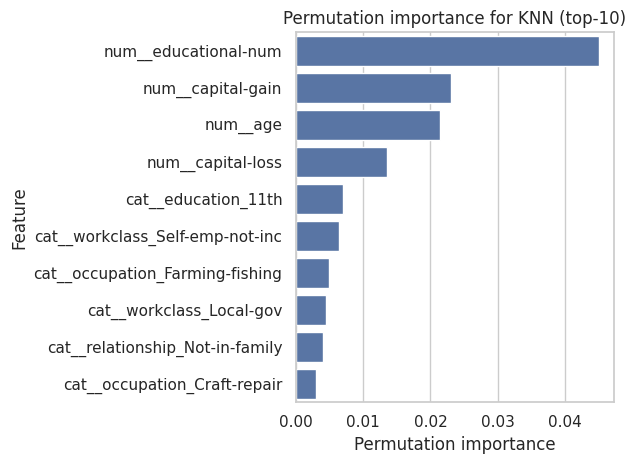

In [ ]:
pipe = gs_knn.best_estimator_ if hasattr(gs_knn, "best_estimator_") else gs_knn
prep = pipe.named_steps['prep']
clf  = pipe.named_steps['clf']

X_test_trans = prep.transform(X_test_)
expanded_names = list(prep.get_feature_names_out(X_test_.columns))
X_pi = X_test_trans.toarray()
res = permutation_importance(clf, X_pi, y_test_, n_repeats=10,
                             random_state=42, n_jobs=-1)
imp = pd.Series(res.importances_mean, index=expanded_names)

top10_idx = imp[imp > 0].sort_values(ascending=False).head(10).index
top10 = imp.reindex(top10_idx)

df_top10 = top10.sort_values(ascending=False).reset_index()
df_top10.columns = ["Feature", "Permutation importance"]

sns.barplot(data=df_top10, x="Permutation importance", y="Feature")
plt.title("Permutation importance for KNN (top-10)")
plt.tight_layout()
plt.show()

So, out of all features, the education level played the most important role in KNN-predictions.

#### Logistic Regression

Logistic regression is very interpretable, because during training it connects each feature with the probability of a class through coefficients. Moreover, the coefficient sign indicates which class a particular feature inclines to.

So, here we don't need any third-party calculations -- only model parameters:

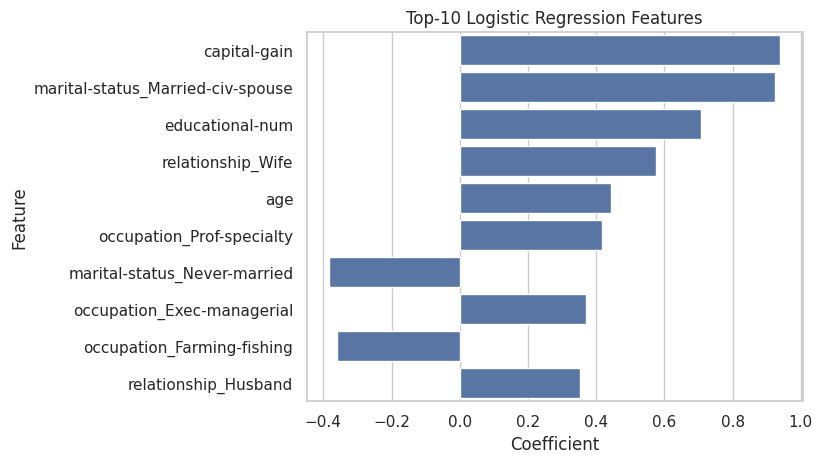

In [ ]:
coef = gs_log.best_estimator_['clf'].coef_[0]
features = gs_log.best_estimator_['prep'].transformers_[0][2] + \
           gs_log.best_estimator_['prep'].transformers_[1][1].get_feature_names_out(categorical_cols).tolist()

coef_df = pd.DataFrame({"Feature": features, "Coefficient": coef})
coef_df = coef_df.sort_values("Coefficient", ascending=False)

top10 = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(10)

sns.barplot(data=top10, x="Coefficient", y="Feature")
plt.title("Top-10 Logistic Regression Features")
plt.show()

From Logistic regression top-features we can see that the highest positive coefficient is held by `capital-gain` (in particular `0.94`), indicating that its higher values really increase the likelihood of the sample of being classified as class 1. On the other hand, the feature with the most negative coefficient is `marital-status_Never-married` (`-0.38`), which decreases the probability of class 1 the most.

#### Naive Bayes

GaussianNB provides us with such parameters as `theta_`, which is the mean of the feature for each class (common feature's value for the class), and `var_` -- variance (the spread of attribute values within class).

It is easy to interpret:

For numerical features:

* if `theta_` for class 1 is higher than for class 0 -> big feature's values lean us towards class 1 and vice versa.

For binary features:

They are also considered continuous and obtain the same `theta_`:

* for whichever class `theta_` is higher - feature appears there more.

* difference `theta_[class1] - theta_[class0]` shows, how much does the attribute distinguish between classes.

In [ ]:
import plotly.express as px

gnb = nb_pipe.named_steps['clf']
prep = nb_pipe.named_steps['prep']

numeric_cols = prep.transformers_[0][2]
cat_cols_ohe = prep.transformers_[1][1].get_feature_names_out(prep.transformers_[1][2]).tolist()
feat_names = numeric_cols + cat_cols_ohe
df_theta_all = pd.DataFrame(gnb.theta_.T, index=feat_names, columns=gnb.classes_)
df_numeric = df_theta_all.loc[numeric_cols]
df_binary  = df_theta_all.loc[cat_cols_ohe]

def plot_nb(df, title, width=1500, height=500, y_max=500, legend=False):
    df_reset = df.reset_index().melt(id_vars='index', var_name='Class', value_name='Mean')
    df_reset.rename(columns={'index':'Feature'}, inplace=True)

    fig = px.bar(df_reset, x='Feature', y='Mean', color='Class', barmode='group',
                 width=width, height=height)
    fig.update_yaxes(range=[0, y_max])
    if legend:
        fig.update_layout(title=title, xaxis={'categoryorder':'total descending'},
                          legend=dict(x=-0.1, y=1))
    else:
        fig.update_layout(title=title, xaxis={'categoryorder':'total descending'})
    fig.show()

plot_nb(df_numeric, "GaussianNB: Mean feature values per class (Numeric data)", width=1200, legend=True)
plot_nb(df_binary, "GaussianNB: Mean feature values per class (Binary data)", width=4000, y_max=1)

#### SVM

SVM itself does not have convenient feature coefficients.

To interpret its results we can, once again, use permutations, as we did for KNN:

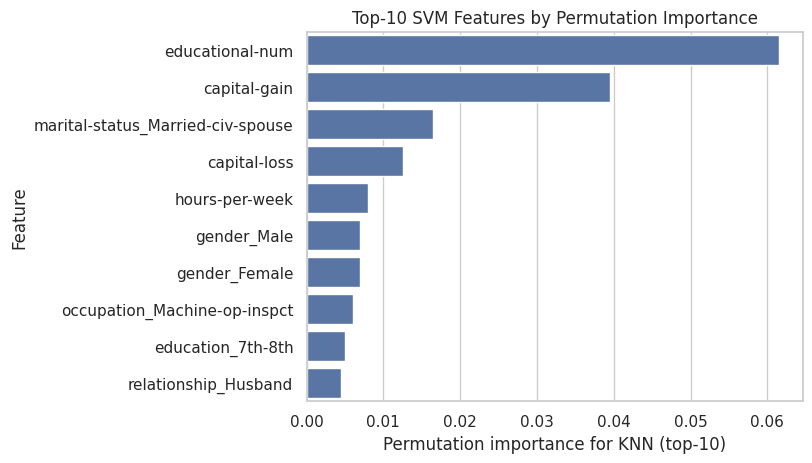

In [ ]:
best_svm = gs_svm.best_estimator_
prep_fitted = best_svm.named_steps['prep']

X_test_trans = prep_fitted.transform(X_test_)
X_pi = X_test_trans.toarray()
numeric_cols = prep_fitted.transformers_[0][2]
cat_cols = prep_fitted.transformers_[1][1].get_feature_names_out(prep_fitted.transformers_[1][2]).tolist()
feat_names = list(numeric_cols) + list(cat_cols)

res = permutation_importance(best_svm.named_steps['clf'], X_pi, y_test_, n_repeats=10, random_state=42, n_jobs=-1)
imp = pd.Series(res.importances_mean, index=feat_names)

top10 = imp.abs().sort_values(ascending=False).head(10)
top10_df = top10.reset_index()
top10_df.columns = ['Feature', 'Importance']

sns.barplot(data=top10_df, x='Importance', y='Feature')
plt.title("Top-10 SVM Features by Permutation Importance")
plt.xlabel("Permutation importance for KNN (top-10)")
plt.ylabel("Feature")
plt.show()

As we saw for KNN model, SVM also considers `educational-num` to be the most significant feature, while the other characteristics in the tops mainly differ.

#### Decision Tree

The decision tree works transparently: it provides information on the basis of which features and their specific values the classification is carried out.

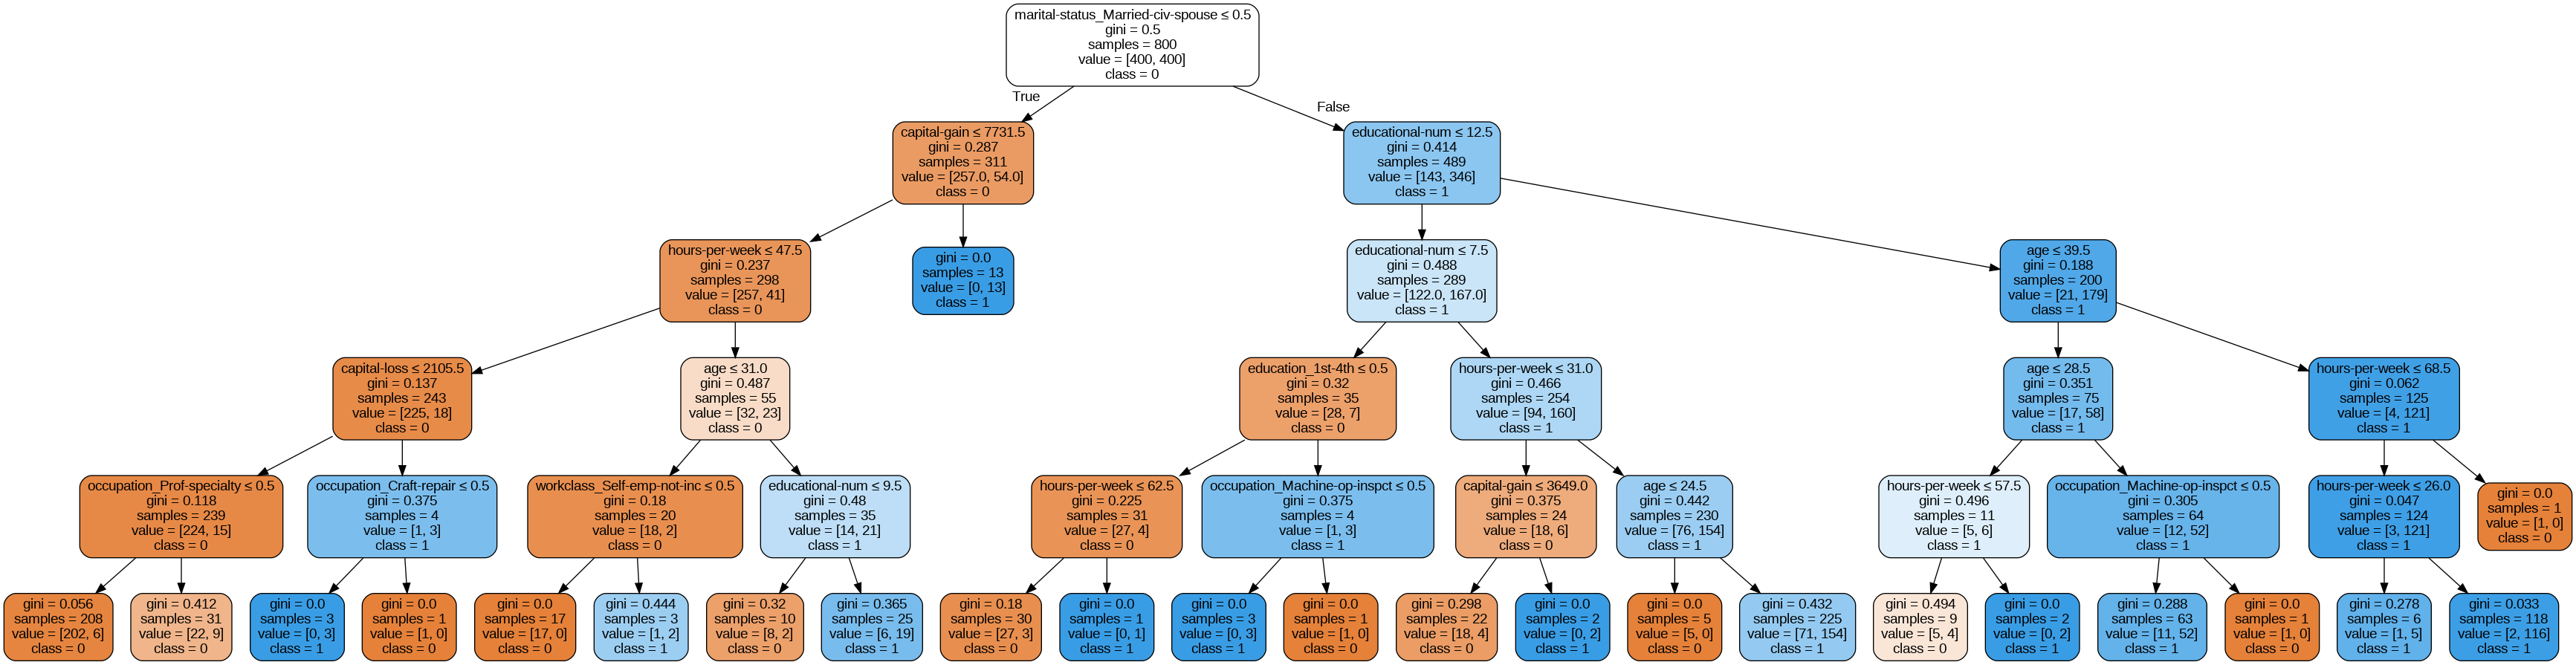

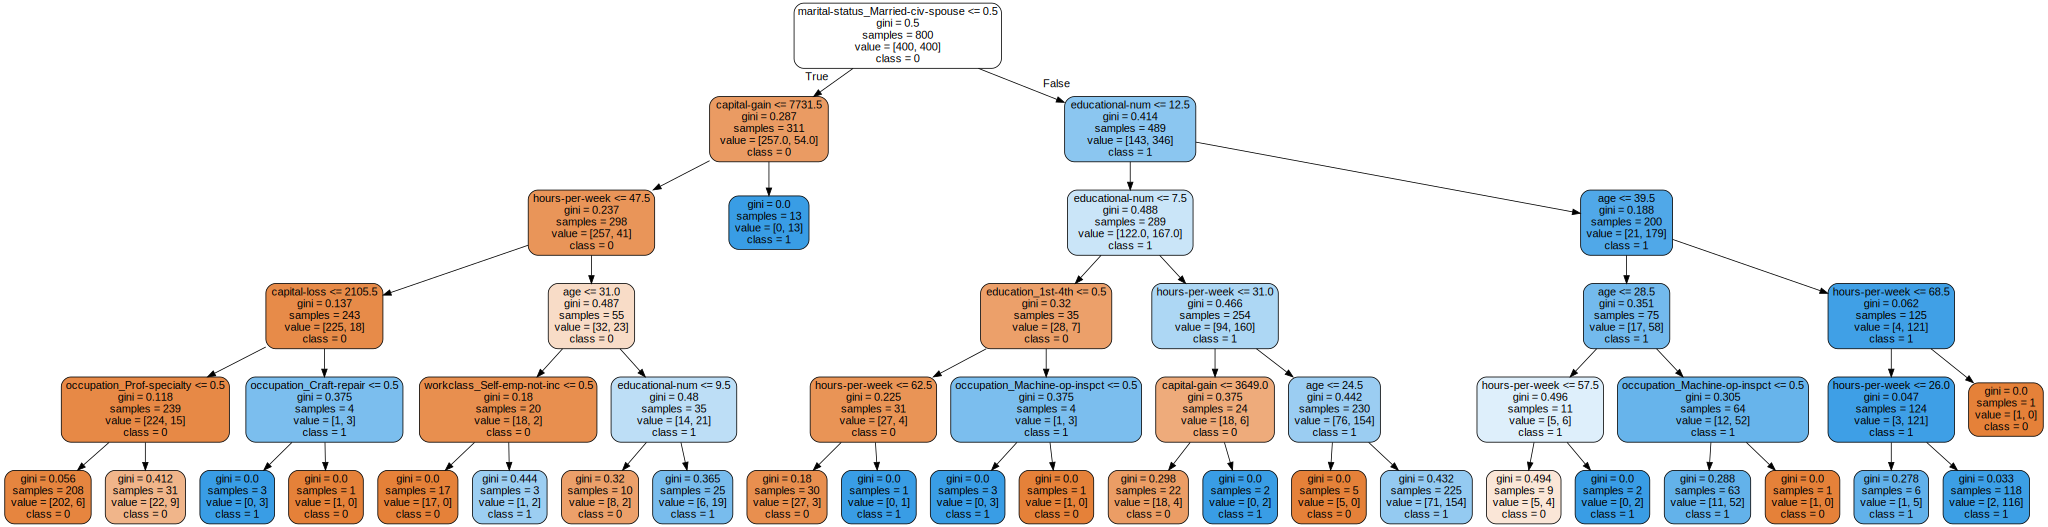

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

tree_clf = gs_tree.best_estimator_.named_steps['clf']


dot_data = export_graphviz(
    tree_clf,
    out_file=None,
    feature_names=features,
    class_names=['0','1'],
    filled=True,
    rounded=True,
)

graph = graphviz.Source(dot_data)
graph

Moreover, trees provide us with obtained importances for each feature:

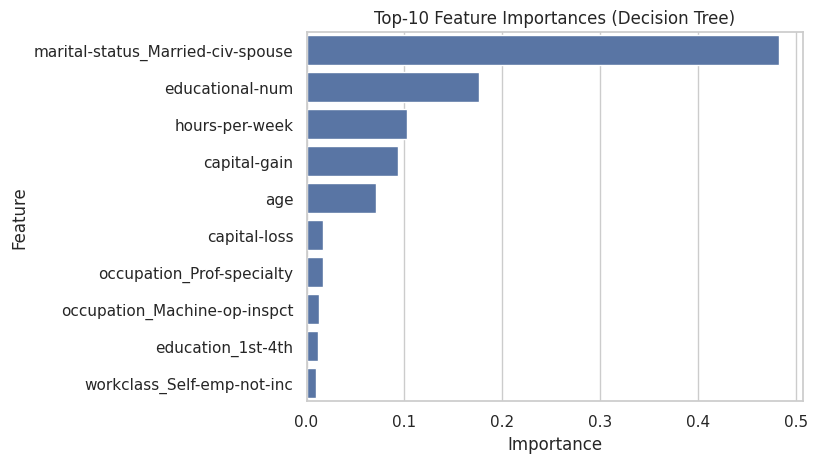

In [ ]:
importances = pd.Series(tree_clf.feature_importances_, index=features)
top10 = importances.sort_values(ascending=False).head(10)

sns.barplot(x=top10.values, y=top10.index)
plt.title("Top-10 Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Accordingly, we see the most important feature as the one by which the first split occurs at the root of the tree. In total, here are 10 features that are most often used in top nodes and provide the greatest improvement in node cleanliness.

### Random forest

Random Forest is an ensemble of several decision trees: each of them is trained on a random subsample of objects and a subset of features. To some extent, this reduces the interpretability of the decisions made by the model, since it is not convenient to output and analyze each tree separately.

However, the algorithm if _, then _ remains unchanged. Also, we can still deduce the importance values assigned to certain features from the parameters of the model itself:

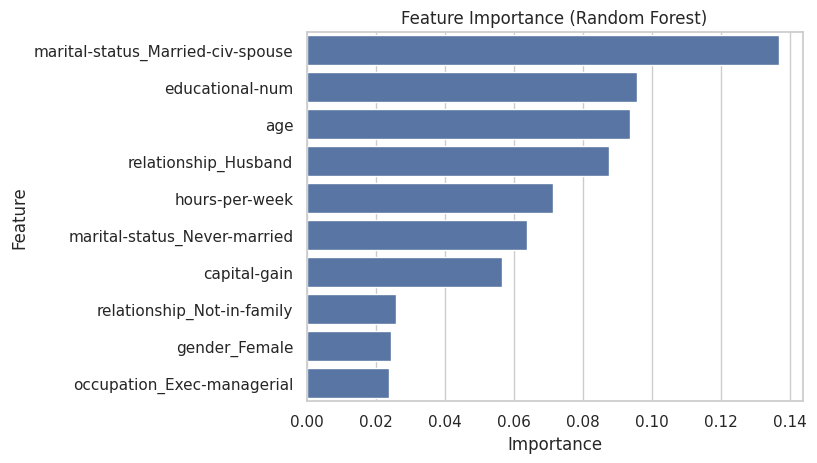

In [ ]:
forest_clf = gs_rf.best_estimator_.named_steps['clf']

importances = forest_clf.feature_importances_
feat_importances = pd.Series(importances, index=features)
top10 = feat_importances.sort_values(ascending=False).head(10)
sns.barplot(x=top10.values, y=top10.index)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Basically, if the feature is often located close to the tops of trees and strongly separates classes, then it gets a high importance.

As we see, top-2 features, obtained with Random forest are the same as they were in Decision tree. The following features got different rank than before, based on many trees' decisions, which, in our case, improved the predictions.

### XGBoost

This model also builds trees, but each subsequent tree corrects the decisions of the previous ones, minimizing the loss function.

XGBoost is still interpretable as calculates the importance for each feature in a clear way:

Importance(feature) = $\sum$(informational_gain from all splits by the feature) / $\sum$(informational_gain of all the splits). However, we don't know the exact algorythm for decision making.

For our data we got the following results:

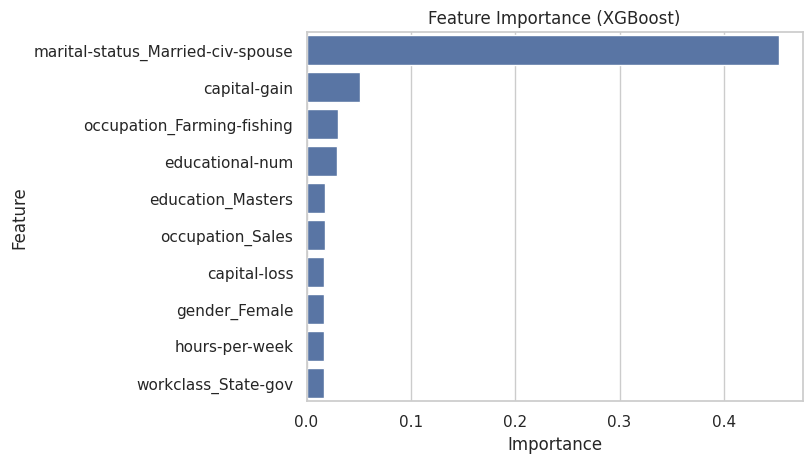

In [ ]:
xgb_model = gs_xgb.best_estimator_.named_steps['clf']
importances = xgb_model.feature_importances_
feat_importances = pd.Series(importances, index=features)
top10 = feat_importances.sort_values(ascending=False).head(10)
sns.barplot(x=top10.values, y=top10.index)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

`marital-status_Married-civ-spouse` continues leading in all tree-based models, carrying the highest gain. In this model it actually exceeds the gain for all other features by about 9 times.

### Lazy FCA (vanilla)

The classifier doesn't have any methods that provide interpretation of the classification, it can only tell the number of classifiers, but not the their insides. Still, these classifiers can be derived using the external fuction

In [ ]:
def get_classifiers_for_sample_external_v2_for_LazyClassifierFCA(model: LazyClassifierFCA, sample: pd.Series) -> Dict[str, List[Dict]]:
    if model.X_train is None or model.y_train is None:
        raise ValueError("Model is not fitted. Call fit() first.")

    X_train_positive = model.X_train[model.y_train == 1]
    X_train_negative = model.X_train[model.y_train == 0]

    binary_cols = X_train_positive.select_dtypes(include='bool').columns.tolist()
    numeric_cols = X_train_positive.select_dtypes(exclude='bool').columns.tolist()

    binary_X_train_positive = X_train_positive[binary_cols]
    numerical_X_train_positive = X_train_positive[numeric_cols]
    binary_X_train_negative = X_train_negative[binary_cols]
    numerical_X_train_negative = X_train_negative[numeric_cols]

    positive_classifiers = []
    negative_classifiers = []

    def find_number_of_positive_and_negative_matches(binary_intersection, numerical_intervals):
        binary_positive_match = (binary_X_train_positive | ~binary_intersection).all(axis=1)
        binary_negative_match = (binary_X_train_negative | ~binary_intersection).all(axis=1)

        numerical_array_pos = numerical_X_train_positive.values
        numerical_array_neg = numerical_X_train_negative.values

        intervals_array = np.array(numerical_intervals)

        numerical_positive_match = ((numerical_array_pos >= intervals_array[:,0]) &
                                    (numerical_array_pos <= intervals_array[:,1])).all(axis=1)
        numerical_negative_match = ((numerical_array_neg >= intervals_array[:,0]) &
                                    (numerical_array_neg <= intervals_array[:,1])).all(axis=1)

        num_positive = (binary_positive_match & numerical_positive_match).sum()
        num_negative = (binary_negative_match & numerical_negative_match).sum()
        return num_positive, num_negative

    for i, (_, pos_sample) in enumerate(X_train_positive.iterrows()):
        binary_intersection = sample[binary_cols] & pos_sample[binary_cols]
        numerical_intervals = [
            (min(sample[col], pos_sample[col]), max(sample[col], pos_sample[col]))
            for col in numeric_cols
        ]

        num_positive, num_negative = find_number_of_positive_and_negative_matches(
            binary_intersection, numerical_intervals
        )

        if num_negative == 0 and num_positive > 1:
            interval_sizes = [hi - lo for lo, hi in numerical_intervals]
            interval_size_sum = sum(interval_sizes)
            strength = 1.0 / (1.0 + interval_size_sum) * (1.0 + np.log1p(num_positive))

            positive_classifiers.append({
                'sample_class': 1,
                'train_sample_index': i,
                'binary_features': binary_intersection.to_dict(),
                'numerical_features': {col: [lo, hi] for col, (lo, hi) in zip(numeric_cols, numerical_intervals)},
                'covers_positive': int(num_positive),
                'covers_negative': int(num_negative),
            })

    for i, (_, neg_sample) in enumerate(X_train_negative.iterrows()):
        binary_intersection = sample[binary_cols] & neg_sample[binary_cols]

        numerical_intervals = [
            (min(sample[col], neg_sample[col]), max(sample[col], neg_sample[col]))
            for col in numeric_cols
        ]

        num_positive, num_negative = find_number_of_positive_and_negative_matches(
            binary_intersection, numerical_intervals
        )

        if num_positive == 0 and num_negative > 1:
            interval_sizes = [hi - lo for lo, hi in numerical_intervals]
            interval_size_sum = sum(interval_sizes)
            strength = 1.0 / (1.0 + interval_size_sum) * (1.0 + np.log1p(num_negative))

            negative_classifiers.append({
                'sample_class': 0,
                'train_sample_index': i,
                'binary_features': binary_intersection.to_dict(),
                'numerical_features': {col: [lo, hi] for col, (lo, hi) in zip(numeric_cols, numerical_intervals)},
                'covers_positive': int(num_positive),
                'covers_negative': int(num_negative),
            })

    return {
        'positive': positive_classifiers,
        'negative': negative_classifiers
    }

In [ ]:
clfs = get_classifiers_for_sample_external_v2_for_LazyClassifierFCA(classifier, X_test_fca_preprocessed.iloc[2])
print("Positive classifiers:", len(clfs['positive']))
print("Negative classifiers:", len(clfs['negative']))
print()
clfs['negative'][0]

Positive classifiers: 1
Negative classifiers: 158



{'sample_class': 0,
 'train_sample_index': 0,
 'binary_features': {'workclass_Private': True,
  'workclass_Local-gov': False,
  'workclass_State-gov': False,
  'workclass_Self-emp-inc': False,
  'workclass_Self-emp-not-inc': False,
  'workclass_Federal-gov': False,
  'workclass_Without-pay': False,
  'education_HS-grad': False,
  'education_Bachelors': False,
  'education_Prof-school': False,
  'education_Assoc-voc': False,
  'education_Doctorate': False,
  'education_Masters': False,
  'education_11th': False,
  'education_Some-college': False,
  'education_Assoc-acdm': False,
  'education_10th': False,
  'education_5th-6th': False,
  'education_9th': False,
  'education_12th': False,
  'education_7th-8th': False,
  'education_1st-4th': False,
  'education_Preschool': False,
  'marital-status_Married-civ-spouse': False,
  'marital-status_Divorced': False,
  'marital-status_Never-married': False,
  'marital-status_Widowed': False,
  'marital-status_Separated': False,
  'marital-status_

This way we can analyze, why a certain sample was assigned to a particular class, go through classifiers and check how many positive/negative train samples have the same classifier.

### Improved Lazy FCA classifier number 1


The improved version of FCA classification has a built-in method that allows you to display all of the classifiers for each specific sample, for example:


In [ ]:
sample = X_test_fca_preprocessed.iloc[0]
y_test_.iloc[0]

np.int64(0)

In [ ]:
explanation = classifier_improved.explain_sample(sample)

print(f"Positive classifiers: {len(explanation['positive'])}")
print(f"Negative classifiers: {len(explanation['negative'])}")

Positive classifiers: 39
Negative classifiers: 187


In [ ]:
sorted_pos = sorted(explanation['positive'], key=lambda x: x['strength'], reverse=True)
sorted_neg = sorted(explanation['negative'], key=lambda x: x['strength'], reverse=True)

clf = sorted_neg[0]

print("=== The strongest negative classifier: ===")
print(f"Strength: {clf['strength']:.4f}")
print(f"Support: +{clf['support_pos']} / -{clf['support_neg']}")

print("Binary features:")
if clf['binary_features']:
    for k, v in clf['binary_features'].items():
        print(f"  - {k}: {v}")

print("Numerical intervals:")
if clf['numeric_features']:
    for k, v in clf['numeric_features'].items():
        print(f"  - {k}: [{v[0]:.2f}, {v[1]:.2f}]")

=== The strongest negative classifier: ===
Strength: 2.0986
Support: +0 / -2
Binary features:
  - workclass_Private: True
  - education_Some-college: True
  - marital-status_Never-married: True
  - race_White: True
  - gender_Male: True
Numerical intervals:
  - age: [24.00, 24.00]
  - educational-num: [10.00, 10.00]
  - capital-gain: [0.00, 0.00]
  - capital-loss: [0.00, 0.00]
  - hours-per-week: [40.00, 40.00]


### Improved Lazy FCA classifier number 2

Here, we didn't do the built-in method, but the ckassifiers are still accesseble, using the fuction `get_classifiers_for_sample_external_v2_for_LazyClassifierFCA()`, which we made for the Vanilla version:

In [ ]:
clfs = get_classifiers_for_sample_external_v2_for_LazyClassifierFCA(classifier_mod2, X_test_fca_preprocessed.iloc[2])
print("Positive classifiers:", len(clfs['positive']))
print("Negative classifiers:", len(clfs['negative']))
print()
clfs['negative'][0]

Positive classifiers: 1
Negative classifiers: 158



{'sample_class': 0,
 'train_sample_index': 0,
 'binary_features': {'workclass_Private': True,
  'workclass_Local-gov': False,
  'workclass_State-gov': False,
  'workclass_Self-emp-inc': False,
  'workclass_Self-emp-not-inc': False,
  'workclass_Federal-gov': False,
  'workclass_Without-pay': False,
  'education_HS-grad': False,
  'education_Bachelors': False,
  'education_Prof-school': False,
  'education_Assoc-voc': False,
  'education_Doctorate': False,
  'education_Masters': False,
  'education_11th': False,
  'education_Some-college': False,
  'education_Assoc-acdm': False,
  'education_10th': False,
  'education_5th-6th': False,
  'education_9th': False,
  'education_12th': False,
  'education_7th-8th': False,
  'education_1st-4th': False,
  'education_Preschool': False,
  'marital-status_Married-civ-spouse': False,
  'marital-status_Divorced': False,
  'marital-status_Never-married': False,
  'marital-status_Widowed': False,
  'marital-status_Separated': False,
  'marital-status_